In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from math import acos, degrees
from scipy.signal import find_peaks
import os.path
import glob
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import entropy
import pylab as pl
from numpy.fft import fft
from scipy import stats
import numpy
from scipy import signal
from scipy.signal import lfilter, lfilter_zi, filtfilt, butter
import matplotlib.patches as mpatches

In [4]:
%matplotlib notebook

In [5]:
%matplotlib inline

In [6]:
plt.style.use('default')

In [7]:
chunk_width = 200
#centr_rang = 110

In [8]:
#Function to extract angle using 3 points coordinate
def angle3pt(a, b, c):
#    """Counterclockwise angle in degrees by turning from c to a around b
#        Returns a float between 0.0 and 360.0"""
    ang = math.degrees(
    math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang


In [9]:
def getridofAngleJumps(alpha):
    alpha_rad = [x*(np.pi)/180 for x in alpha]
    alpha_rad = np.array(alpha_rad)
    alpha_rad[~np.isnan(alpha_rad)] = np.unwrap(alpha_rad[~np.isnan(alpha_rad)])
    alpha_unwrap= np.degrees(alpha_rad)
    return alpha_unwrap

In [10]:
def smooth_acausal(x,frequency = 0.300):
    #b, a = signal.butter(8, 0.150)
    sos = signal.butter(4, frequency, output='sos')
    y = signal.sosfiltfilt(sos, x)
    return y


In [11]:
def smooth(x,window_len=1,window='hanning'):
#    """smooth the data using a window with requested size.
#    
#    This method is based on the convolution of a scaled window with the signal.
#    The signal is prepared by introducing reflected copies of the signal 
#    (with the window size) in both ends so that transient parts are minimized
#    in the begining and end part of the output signal.
#    
#    input:
#        x: the input signal 
#        window_len: the dimension of the smoothing window; should be an odd integer
#        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
#            flat window will produce a moving average smoothing.
#
#    output:
#        the smoothed signal
#        
#    example:
#
#    t=linspace(-2,2,0.1)
#    y=smooth(x)
#    
#    
#    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
#    scipy.signal.lfilter
 
#    TODO: the window parameter could be the window itself if an array instead of a string
#    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


In [12]:
#Function to extract RidgeX trajectory from excel file
def RidgeX_excel_to_array_preprocessed(file_path, chunk_width, trial_no):
    #Read csv file tail markers
    RidgeX = pd.read_csv(file_path[trial_no])

    #take just numeric values
    RidgeX=pd.to_numeric(RidgeX.iloc[:,0])

 
    return smooth(RidgeX.values)


In [13]:
#Function to plot tail angle trajectory
def plot_TailAngle(file_path, chunk_width, i, c):
    #Read csv file tail markers
    df = pd.read_csv(file_path[i])
#    df = pd.read_csv(file_path)

    #Rename marker columns
    df.rename(columns={'DLC_resnet50_Ridge_walkMay27shuffle1_200000':'tail1_x',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_200000.1':'tail1_y',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_200000.2':'tail1_lik',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_200000.3':'tail2_x',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_200000.4':'tail2_y',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_200000.5':'tail2_lik',                       
                          'DLC_resnet50_Ridge_walkMay27shuffle1_200000.6':'tail3_x',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_200000.7':'tail3_y',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_200000.8':'tail3_lik'}, 
                 inplace=True)

    #take just numeric values
    df.tail1_x=pd.to_numeric(df.tail1_x[c-chunk_width:c+chunk_width])
    df.tail1_y=pd.to_numeric(df.tail1_y[c-chunk_width:c+chunk_width])
    df.tail2_x=pd.to_numeric(df.tail2_x[c-chunk_width:c+chunk_width])
    df.tail2_y=pd.to_numeric(df.tail2_y[c-chunk_width:c+chunk_width])
    df.tail3_x=pd.to_numeric(df.tail3_x[c-chunk_width:c+chunk_width])
    df.tail3_y=pd.to_numeric(df.tail3_y[c-chunk_width:c+chunk_width])
    df.tail1_lik=pd.to_numeric(df.tail1_lik[c-chunk_width:c+chunk_width])
    df.tail2_lik=pd.to_numeric(df.tail2_lik[c-chunk_width:c+chunk_width])
    df.tail3_lik=pd.to_numeric(df.tail3_lik[c-chunk_width:c+chunk_width])
    
    #substitute low likelihood points with NaN
    #df.tail1_x[]=np.nan
    lik_thresh = 0.05
    df.tail1_x.where((df.tail1_lik>lik_thresh),np.NaN,inplace=True)
    df.tail1_y.where((df.tail1_lik>lik_thresh),np.NaN,inplace=True)
    df.tail2_x.where((df.tail2_lik>lik_thresh),np.NaN,inplace=True)
    df.tail2_y.where((df.tail2_lik>lik_thresh),np.NaN,inplace=True)
    df.tail3_x.where((df.tail3_lik>lik_thresh),np.NaN,inplace=True)
    df.tail3_y.where((df.tail3_lik>lik_thresh),np.NaN,inplace=True)




    #Compute and plot tail angle in panda dataframe as last column
    angles=[]
    for i in range(df.shape[0]):
        #x1,y1=df.tail1_x[i],df.tail1_y[i]
        vertical = np.array([df.tail1_x[i],df.tail1_y[i]+10])
        tail1 = np.array([df.tail1_x[i],df.tail1_y[i]])
        tail2 = np.array([df.tail2_x[i],df.tail2_y[i]])    
        tail3 = np.array([df.tail3_x[i],df.tail3_y[i]])
    

    #Change below to decide 3 points to determine angle
        angle = angle3pt(tail2, tail1, vertical)
        #Append
        angles.append(round(angle,2))
    df['Angles']=angles
    df.head()
    
    #Create a list comprehension by chunking x (centroid X trajectory) in 'chunk_width' frames and alpha (tail angle traj)
    #x = CentroidXY.X
    alpha = df.Angles
    #Get alpha value at perturbation time to centre the trace to that value
#    alpha_centred = alpha[tot_peaks]
    #Apply function to get rid of angle jumps
    alpha = getridofAngleJumps(alpha)
    #Apply function to smooth
    alpha = smooth(alpha)
#    TailAngle_traj = alpha[tot_peaks-chunk_width:tot_peaks+chunk_width]-[alpha[tot_peaks]-alpha_centred]# for i in tot_peaks]
#!    return [TailAngle_traj, alpha]
    return alpha

In [14]:
#Function to plot Right Paw angle trajectory
def plot_PawAngle(file_path, chunk_width, trial_no):
    #Read csv file tail markers
    df = pd.read_csv(file_path[trial_no])
#    df = pd.read_csv(file_path)

    #Rename marker columns
    df.rename(columns={'DLC_resnet50_Ridge_walkMay27shuffle1_200000.9':'LP_x',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_200000.10':'LP_y',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_200000.11':'LP_lik',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_200000.24':'RA_x',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_200000.25':'RA_y',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_200000.26':'RA_lik',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_200000.21':'RP_x',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_200000.22':'RP_y',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_200000.23':'RP_lik'}, 
                 inplace=True)

    #take just numeric values
    df.RA_x=pd.to_numeric(df.RA_x[2:])
    df.RA_y=pd.to_numeric(df.RA_y[2:])
    df.RP_x=pd.to_numeric(df.RP_x[2:])
    df.RP_y=pd.to_numeric(df.RP_y[2:])
    df.LP_x=pd.to_numeric(df.LP_x[2:])
    df.LP_y=pd.to_numeric(df.LP_y[2:])
    df.RA_lik=pd.to_numeric(df.RA_lik[2:])
    df.RP_lik=pd.to_numeric(df.RP_lik[2:])
    df.LP_lik=pd.to_numeric(df.LP_lik[2:])

    
    #substitute low likelihood points with NaN
    #df.tail1_x[]=np.nan
    lik_thresh = 0.1
    df.RA_x.where((df.RA_lik>lik_thresh),np.NaN,inplace=True)
    df.RA_y.where((df.RA_lik>lik_thresh),np.NaN,inplace=True)
    df.RP_x.where((df.RP_lik>lik_thresh),np.NaN,inplace=True)
    df.RP_y.where((df.RP_lik>lik_thresh),np.NaN,inplace=True)
    df.LP_x.where((df.LP_lik>lik_thresh),np.NaN,inplace=True)
    df.LP_y.where((df.LP_lik>lik_thresh),np.NaN,inplace=True)
    
    #extract RP x and LP x
    RP_x =  df.RP_x
    LP_x =  df.LP_x




    #Compute and plot tail angle in panda dataframe as last column
    angles=[]
    for i in range(df.shape[0]):
        vertical = np.array([df.RA_x[i],df.RA_y[i]+10])
        RA = np.array([df.RA_x[i],df.RA_y[i]])
        RP = np.array([df.RP_x[i],df.RP_y[i]])

        angle = angle3pt(RP, RA, vertical)
        #Append
        angles.append(round(angle,2))
    df['Angles']=angles
    df.head()
    
    #Create a list comprehension by chunking x (centroid X trajectory) in 'chunk_width' frames and alpha (tail angle traj)
    #x = CentroidXY.X
    alpha = df.Angles
    #Get alpha value at perturbation time to centre the trace to that value
#    alpha_centred = alpha[tot_peaks]
    #Apply function to get rid of angle jumps
    alpha = getridofAngleJumps(alpha)
    #Apply function to smooth
    alpha = smooth(alpha)
#    TailAngle_traj = alpha[tot_peaks-chunk_width:tot_peaks+chunk_width]-[alpha[tot_peaks]-alpha_centred]# for i in tot_peaks]
#    RP_x = RP_x[tot_peaks-chunk_width:tot_peaks+chunk_width]-[RP_x[tot_peaks]]
#    LP_x = LP_x[tot_peaks-chunk_width:tot_peaks+chunk_width]-[LP_x[tot_peaks]]

#!    return [TailAngle_traj, alpha]
    return [alpha, smooth(RP_x), smooth(LP_x)]

In [15]:
# #Function to plot Right Paw angle trajectory
# def plot_LPAngle(file_path, chunk_width, trial_no):
#     #Read csv file tail markers
#     df = pd.read_csv(file_path[trial_no])
# #    df = pd.read_csv(file_path)

#     #Rename marker columns
#     df.rename(columns={'DLC_resnet50_Ridge_walkMay27shuffle1_200000.9':'LP_x',
#                           'DLC_resnet50_Ridge_walkMay27shuffle1_200000.10':'LP_y',
#                           'DLC_resnet50_Ridge_walkMay27shuffle1_200000.11':'LP_lik',
#                           'DLC_resnet50_Ridge_walkMay27shuffle1_200000.12':'LA_x',
#                           'DLC_resnet50_Ridge_walkMay27shuffle1_200000.13':'LA_y',
#                           'DLC_resnet50_Ridge_walkMay27shuffle1_200000.14':'LA_lik',
                       
#                           'DLC_resnet50_Ridge_walkMay27shuffle1_200000.24':'RA_x',
#                           'DLC_resnet50_Ridge_walkMay27shuffle1_200000.25':'RA_y',
#                           'DLC_resnet50_Ridge_walkMay27shuffle1_200000.26':'RA_lik',
#                           'DLC_resnet50_Ridge_walkMay27shuffle1_200000.21':'RP_x',
#                           'DLC_resnet50_Ridge_walkMay27shuffle1_200000.22':'RP_y',
#                           'DLC_resnet50_Ridge_walkMay27shuffle1_200000.23':'RP_lik'}, 
#                  inplace=True)

#     #take just numeric values
#     df.RA_x=pd.to_numeric(df.RA_x[2:])
#     df.LA_x=pd.to_numeric(df.LA_x[2:])

#     df.RA_y=pd.to_numeric(df.RA_y[2:])
#     df.LA_y=pd.to_numeric(df.LA_y[2:])

#     df.RP_x=pd.to_numeric(df.RP_x[2:])
#     df.RP_y=pd.to_numeric(df.RP_y[2:])
#     df.LP_x=pd.to_numeric(df.LP_x[2:])
#     df.LP_y=pd.to_numeric(df.LP_y[2:])
    
#     df.RA_lik=pd.to_numeric(df.RA_lik[2:])
#     df.LA_lik=pd.to_numeric(df.LA_lik[2:])
#     df.RP_lik=pd.to_numeric(df.RP_lik[2:])
#     df.LP_lik=pd.to_numeric(df.LP_lik[2:])

    
#     #substitute low likelihood points with NaN
#     #df.tail1_x[]=np.nan
#     lik_thresh = 0.1
#     df.RA_x.where((df.RA_lik>lik_thresh),np.NaN,inplace=True)
#     df.LA_x.where((df.LA_lik>lik_thresh),np.NaN,inplace=True)

#     df.RA_y.where((df.RA_lik>lik_thresh),np.NaN,inplace=True)
#     df.LA_y.where((df.LA_lik>lik_thresh),np.NaN,inplace=True)

#     df.RP_x.where((df.RP_lik>lik_thresh),np.NaN,inplace=True)
#     df.RP_y.where((df.RP_lik>lik_thresh),np.NaN,inplace=True)
#     df.LP_x.where((df.LP_lik>lik_thresh),np.NaN,inplace=True)
#     df.LP_y.where((df.LP_lik>lik_thresh),np.NaN,inplace=True)
    
#     #extract RP x and LP x
#     RP_x =  df.RP_x
#     LP_x =  df.LP_x




#     #Compute and plot tail angle in panda dataframe as last column
#     angles=[]
#     for i in range(df.shape[0]):
#         vertical = np.array([df.LA_x[i],df.LA_y[i]+10])
#         LA = np.array([df.LA_x[i],df.LA_y[i]])
#         LP = np.array([df.LP_x[i],df.LP_y[i]])

#         angle = angle3pt(LP, LA, vertical)
#         #Append
#         angles.append(round(angle,2))
#     df['Angles']=angles
#     df.head()
    
#     #Create a list comprehension by chunking x (centroid X trajectory) in 'chunk_width' frames and alpha (tail angle traj)
#     #x = CentroidXY.X
#     alpha = df.Angles
#     #Get alpha value at perturbation time to centre the trace to that value
# #    alpha_centred = alpha[tot_peaks]
#     #Apply function to get rid of angle jumps
#     alpha = getridofAngleJumps(alpha)
#     #Apply function to smooth
#     alpha = smooth(alpha)
# #    TailAngle_traj = alpha[tot_peaks-chunk_width:tot_peaks+chunk_width]-[alpha[tot_peaks]-alpha_centred]# for i in tot_peaks]
# #    RP_x = RP_x[tot_peaks-chunk_width:tot_peaks+chunk_width]-[RP_x[tot_peaks]]
# #    LP_x = LP_x[tot_peaks-chunk_width:tot_peaks+chunk_width]-[LP_x[tot_peaks]]

# #!    return [TailAngle_traj, alpha]
#     return [alpha, smooth(RP_x), smooth(LP_x)]

In [16]:
#Function to plot Right Paw angle trajectory
def plot_HipAngle(file_path, chunk_width, trial_no, c):
    #Read csv file tail markers
    df = pd.read_csv(file_path[trial_no])
#    df = pd.read_csv(file_path)

    #Rename marker columns
    df.rename(columns={'DLC_resnet50_Ridge_walkMay27shuffle1_200000.15':'LH_x',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_200000.16':'LH_y',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_200000.17':'LH_lik',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_200000.18':'RH_x',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_200000.19':'RH_y',
                          'DLC_resnet50_Ridge_walkMay27shuffle1_200000.20':'RH_lik'}, 
                 inplace=True)

    #take just numeric values
    df.LH_x=pd.to_numeric(df.LH_x[c-chunk_width:c+chunk_width])
    df.LH_y=pd.to_numeric(df.LH_y[c-chunk_width:c+chunk_width])
    df.RH_x=pd.to_numeric(df.RH_x[c-chunk_width:c+chunk_width])
    df.RH_y=pd.to_numeric(df.RH_y[c-chunk_width:c+chunk_width])
    df.RH_lik=pd.to_numeric(df.RH_lik[c-chunk_width:c+chunk_width])
    df.LH_lik=pd.to_numeric(df.LH_lik[c-chunk_width:c+chunk_width])
    
    

    
    #substitute low likelihood points with NaN
    #df.tail1_x[]=np.nan
    lik_thresh = 0.1
    df.LH_x.where((df.LH_lik>lik_thresh),np.NaN,inplace=True)
    df.LH_y.where((df.LH_lik>lik_thresh),np.NaN,inplace=True)
    df.RH_x.where((df.RH_lik>lik_thresh),np.NaN,inplace=True)
    df.RH_y.where((df.RH_lik>lik_thresh),np.NaN,inplace=True)

    
    #extract RP x and LP x
    LH_x =  df.LH_x
    LH_y =  df.LH_y
    RH_x =  df.RH_x    
    RH_y =  df.RH_y




    #Compute and plot tail angle in panda dataframe as last column
    angles=[]
    for i in range(df.shape[0]):
        vertical = np.array([df.RH_x[i],df.RH_y[i]+10])
        RH = np.array([df.RH_x[i],df.RH_y[i]])
        LH = np.array([df.LH_x[i],df.LH_y[i]])

        angle = angle3pt(LH, RH, vertical)
        #Append
        angles.append(round(angle,2))
    df['Angles']=angles
    df.head()
    
    #Create a list comprehension by chunking x (centroid X trajectory) in 'chunk_width' frames and alpha (tail angle traj)
    #x = CentroidXY.X
    alpha = df.Angles
    #Get alpha value at perturbation time to centre the trace to that value
#    alpha_centred = alpha[tot_peaks]
    #Apply function to get rid of angle jumps
    alpha = getridofAngleJumps(alpha)
    #Apply function to smooth
    alpha = smooth(alpha)
#    TailAngle_traj = alpha[tot_peaks-chunk_width:tot_peaks+chunk_width]-[alpha[tot_peaks]-alpha_centred]# for i in tot_peaks]
#    RP_x = RP_x[tot_peaks-chunk_width:tot_peaks+chunk_width]-[RP_x[tot_peaks]]
#    LP_x = LP_x[tot_peaks-chunk_width:tot_peaks+chunk_width]-[LP_x[tot_peaks]]

#!    return [TailAngle_traj, alpha]
    return alpha

In [17]:
#Function to extract centroid X Y trajectory
def extract_Centroid(file_path, chunk_width, trial_no):
    #Read csv file tail markers
    CentroidXY = pd.read_csv(file_path[trial_no])

    CentroidXY.rename(columns={'NaN':'X',
                              'NaN.1':'Y'}, 
                     inplace=True)
    #take just numeric values
    CentroidXY.Centroid_x=pd.to_numeric(CentroidXY.X)
    CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)

    #extract Centroid x and y
    CentroidX =  CentroidXY.Centroid_x.values
    CentroidY =  CentroidXY.Centroid_y.values
    CentroidX = [el for el in CentroidX]
    CentroidY = [el for el in CentroidY]

    return np.array(CentroidX).ravel(), np.array(CentroidY).ravel()


In [18]:
def find_delay(a, b):
    corr_a_b = np.correlate(a-np.mean(a), b-np.mean(b), mode = 'full')
    delay = np.where(corr_a_b == numpy.amin(corr_a_b))# -(np.size(corr_a_b)+1)/2
    return delay[0]-(np.size(corr_a_b)+1)/2

In [19]:
#Function to plot Right Paw angle trajectory
def plot_Centroid_edge_dist(file_path, chunk_width, i):
    #Read csv file tail markers
    df = pd.read_csv(file_path[i])

##Open Centroid file from top camera
#CentroidXY = pd.read_csv('C:/Users/Salvo/Desktop/Ridge/DLC_videos/Videos_to_analyzeDLC/Ridge_MiceS20-S24_16thApril/perturbation_8mm_1/8_S22/Centroid.csv')

    #Select 1st column csv file
    matrix2 = df[df.columns[0]]#.as_matrix()
    Centroid1stcol = matrix2.tolist() #file 1st column


#    CentroidXY.rename(columns={'NaN':'dist'}, 
#                     inplace=True)
    #take just numeric values
    Centroid1stcol = pd.to_numeric(Centroid1stcol)
#    CentroidXY.Centroid_y=pd.to_numeric(CentroidXY.Y)

    #extract Centroid x and y
#    CentroidX =  CentroidXY.Centroid_x
#    CentroidY =  CentroidXY.Centroid_y
    
#    Centroid_list = CentroidX[tot_peaks-chunk_width:tot_peaks+centr_rang-chunk_width]#-[CentroidX[tot_peaks]]
    
#    Centroid_list = CentroidX[tot_peaks-chunk_width-100:tot_peaks-100]-[CentroidX[tot_peaks-100]]
    return smooth(Centroid1stcol)

In [20]:
#np.arange(len(file_to_open)-25)


In [21]:

def firstNonNan(listfloats):
    i = 0
    for item in listfloats:
        i += 1
        if math.isnan(item) == False:
            return i

#firstNonNan(t)

In [22]:
def HIST_MI_2_var(a, b):
    fig = plt.figure(figsize=(10,14))
    ax1 = plt.subplot(311)
    ax2 = plt.subplot(312)
    hist_centr = ax1.hist(a, density=True, bins=30, color = 'orange')  # `density=False` would make counts
    hist_tail = ax2.hist(b, density=True, bins=30, color = 'blue')  # `density=False` would make counts
#    ent_cent = entropy(hist_centr[0], base=2)
#    ent_tail = entropy(hist_tail[0], base=2)
    MI_cent_tail = metrics.mutual_info_score(hist_centr[0], hist_tail[0])
    return MI_cent_tail

In [23]:
def get_delay_array(var1, var2):
    var1 = var1[~np.isnan(var1)] #centroid
    var2 = var2[~np.isnan(var2)] #TA
    #take the mean out
#    var1 = var1-np.mean(var1)
#    var2 = var2-np.mean(var2)

    corr_a_b = np.correlate(var2, var1, mode = 'full')
    norm_corr_a_b = np.correlate(var2/np.std(var2), var1/np.std(var1), mode = 'full')
    cc_trace_midpoint = len(norm_corr_a_b)
    delay = np.argmax(abs(norm_corr_a_b))-(cc_trace_midpoint/2)+1 #Get the delay of the absolute max peak
    max_peak = max(norm_corr_a_b, key=abs)
#    max_peak = abs(max(corr_a_b, key=abs))
    return delay, max_peak

In [24]:
def get_fft(chunk_width, data):
    # Number of sample points
    N = chunk_width*2
    # sample spacing
    T = 1/300
    x = np.linspace(0.0, N*T, N)
    y = data
    yf = fft(y)
    xf = np.linspace(0, 1/(2*T), N//2)
#    plt.plot(xf, 2/N * np.abs(yf[0:N//2]))
#    plt.grid()
#    plt.show()
    return xf, yf

In [25]:
def findpeaks_extractchunk(x_diff, x, y, z, w, t, threshold_height, chunk_width_step):
    peaks, _ = find_peaks(x_diff, height=threshold_height)
    out_step = []
    out_TA = []
    out_HA = []
    out_cent = []
    out_RstepAng = []

    for i in np.arange(len(peaks)):
        chunk_trial_step = x[peaks[i]-chunk_width_step:peaks[i]+chunk_width_step]
        chunk_trial_TA = y[peaks[i]-chunk_width_step:peaks[i]+chunk_width_step]
        chunk_trial_HA = z[peaks[i]-chunk_width_step:peaks[i]+chunk_width_step]
        chunk_trial_cent = w[peaks[i]-chunk_width_step:peaks[i]+chunk_width_step]
        chunk_trial_RstepAng = t[peaks[i]-chunk_width_step:peaks[i]+chunk_width_step]
        

        out_step.append(chunk_trial_step)
        out_TA.append(chunk_trial_TA)
        out_HA.append(chunk_trial_HA)
        out_cent.append(chunk_trial_cent)
        #transpose all traces of step angle greater than 360 back to 0
        if np.nanmean(chunk_trial_RstepAng) > 250:
            out_RstepAng.append(chunk_trial_RstepAng-360)
        elif np.nanmean(chunk_trial_RstepAng) < -150:
            out_RstepAng.append(chunk_trial_RstepAng+360)   
        else:
            out_RstepAng.append(chunk_trial_RstepAng)


    
    return out_step, out_TA, out_HA, out_cent, out_RstepAng

In [26]:
import matplotlib.pyplot as plt
import matplotlib.text as mpl_text

class AnyObject(object):
    def __init__(self, text, color):
        self.my_text = text
        self.my_color = color

class AnyObjectHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        print(orig_handle)
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch = mpl_text.Text(x=0, y=0, text=orig_handle.my_text, color=orig_handle.my_color, verticalalignment=u'baseline', 
                                horizontalalignment=u'left', multialignment=None, 
                                fontproperties=None, rotation=45, linespacing=None, 
                                rotation_mode=None)
        handlebox.add_artist(patch)
        return patch

In [27]:
def delete_bad_traces_FromList(Traces_List, idx_to_eliminate):
    for l in np.arange(len(idx_to_eliminate)):
        for i in np.arange(len(Traces_List)):
            for j in np.arange(len(Traces_List[i])):
                if len(Traces_List[i][j]) == 200:
                    if i == idx_to_eliminate[l][0] and j == idx_to_eliminate[l][1]:
                        Traces_List[i][j] = [] 
    return Traces_List

In [28]:
# def check_trace(trace):
#     if np.nanmean(trace) <-50:
#         trace = trace + 360
# #    if np.nanmean(trace) >400:
# #        trace = trace - 360
#     return trace

In [29]:
# def check_trace_within_0_to_150(trace):
#     if np.nanmean(trace) <-50:
#         trace = trace + 360
#         if np.nanmean(trace) <-50:
#             trace = trace + 360
# #    elif np.nanmean(trace[0:60]) >150:
# #        trace = []
#     else:
#         trace = trace
#     return trace

In [30]:
# print(len(RidgeX_ExcelList_to_open), len(TA_ExcelList_to_open), len(Centroid_ExcelList_to_open), \
#       len(BodyAxis_ExcelList_to_open))

In [31]:
def fill_nan(arr):
#     mask = np.isnan(arr)
#     idx = np.where(~mask,np.arange(mask.size),0)
#     np.maximum.accumulate(idx, out=idx)
#     arr[mask] = arr[idx]
    df = pd.DataFrame(data=arr.flatten())
    df = df.fillna(value=None, method='backfill', axis=None, limit=70, downcast=None)
    arr = df.values
#    print(type(arr))
    return arr.ravel()

In [32]:
### Organize all data into python dict
from collections import defaultdict

search_key_path = ['*4mm*', '*_5mm*', '*8mm*', '*10mm*']#['*']
search_key = ['4mm', '5mm', '8mm', '10mm']

dict_ridge_widths = defaultdict(dict)
dict_ridge_all = defaultdict(dict)
for j in np.arange(len(search_key_path)):
    data_location = "R:/UusisaariU/PROCESSED_DATA_BACKUPS/nRIM_MEMBERS/Salvo/Ridge_Dec2020_March2021_preprocessed/Ridge_Dec2020"#"E:/Ridge_Dec2020/"
    RidgeX_ExcelList_to_open = glob.glob(os.path.join(os.path.sep, data_location, search_key_path[j], 'Ridge_X/*.csv'))
    TA_ExcelList_to_open = glob.glob(os.path.join(os.path.sep, data_location, search_key_path[j], 'side_cam/*/*.csv'))
    Centroid_ExcelList_to_open = glob.glob(os.path.join(os.path.sep, data_location, search_key_path[j], 'Centroid_XY/*.csv'))
    BodyAxis_ExcelList_to_open = glob.glob(os.path.join(os.path.sep, data_location, search_key_path[j], 'BodyAxis/*.csv'))
#    fig, ax1 = plt.subplots(1, 1, figsize=(15,6))
#    print(RidgeX_ExcelList_to_open)
#    dict_ridge = {}
    for i in np.arange(len(RidgeX_ExcelList_to_open)): # len(peaks)
        fig, ax1 = plt.subplots(1, 1, figsize=(15,6))
        #Extract arrays
        RidgeX_traj = RidgeX_excel_to_array_preprocessed(RidgeX_ExcelList_to_open, chunk_width, i)
        BodyAxis_traj = RidgeX_excel_to_array_preprocessed(BodyAxis_ExcelList_to_open, chunk_width, i)
        CentroidX_traj, CentroidY_traj = extract_Centroid(Centroid_ExcelList_to_open, chunk_width, i)

        #Extract traces of Centroid and Tail Angle around the time frame when the mouse is at the ridge center
        a = firstNonNan(CentroidX_traj)
        b = round((np.size(CentroidX_traj) - np.count_nonzero(np.isnan(CentroidX_traj)))/2)
        c = a + b

        #Take tail angle traj after extracting chunk of traj of interest around c
        TailAngle_traj = plot_TailAngle(TA_ExcelList_to_open, chunk_width, i, c)
        HipAngle_traj = plot_HipAngle(TA_ExcelList_to_open, chunk_width, i, c)
        pawangle, RPaw_traj, LPaw_traj = plot_PawAngle(TA_ExcelList_to_open, chunk_width, i)
        
        RidgeX_traj_chunk = fill_nan(RidgeX_traj[c-chunk_width:c+chunk_width])
        TailAngle_traj_chunk = fill_nan(TailAngle_traj[c-chunk_width:c+chunk_width])
        HipAngle_traj_chunk = fill_nan(HipAngle_traj[c-chunk_width:c+chunk_width])
        RPaw_traj_traj_chunk = RPaw_traj[c-chunk_width:c+chunk_width]
        LPaw_traj_traj_chunk = LPaw_traj[c-chunk_width:c+chunk_width]
        BodyAxis_traj_chunk = fill_nan(BodyAxis_traj[c-chunk_width:c+chunk_width])

        #TailAngle_traj_chunk_corrected = check_trace(TailAngle_traj_chunk)
        CentroidX_traj_chunk = fill_nan(CentroidX_traj[c-chunk_width:c+chunk_width])
        #print(CentroidX_traj_chunk.ravel())
        CentroidY_traj_chunk = fill_nan(CentroidY_traj[c-chunk_width:c+chunk_width])
        CentroidX_chunk  = fill_nan(CentroidX_traj[c-chunk_width:c+chunk_width])
        CentroidX_chunk_withoutNaN = fill_nan(CentroidX_traj[~np.isnan(CentroidX_traj)]) #drop NaN

        #Decide here what variables to plot in the three figures
        var1 = np.array(RidgeX_traj_chunk)
        var2 = np.array(TailAngle_traj_chunk)
        var3 = np.array(CentroidX_traj_chunk)
        var4 = np.array([RPaw_traj_traj_chunk, LPaw_traj_traj_chunk, HipAngle_traj_chunk, BodyAxis_traj_chunk, \
                        CentroidY_traj_chunk, CentroidX_traj_chunk])
        var5 = CentroidX_traj_chunk
        #Plot traces
        x1 = np.arange(len(var1))
        x2 = np.arange(len(var5))
        x3 = np.arange(len(var3))
        ax1.plot(x1, var1, color = 'red')
        ax1.plot(x2, var5, color = 'black')
#        ax1.plot(np.arange(len(BodyAxis_traj_chunk)), BodyAxis_traj_chunk, color = 'green')
#        ax1.plot(np.arange(len(LPaw_traj_traj_chunk)), LPaw_traj_traj_chunk, color = 'magenta')
        key_file_name = os.path.basename(RidgeX_ExcelList_to_open[i])
        ax1.set_title(key_file_name)

#         ax1.set_xlabel('Frames (300 Hz)')
#         ax1.set_ylabel('Tail Angle Velocity (degrees)')
        #Make dict
        dict_ridge_widths[search_key[j]][key_file_name] = [var1, var2, var3, var4]

        dict_ridge_all['all'][key_file_name] = [var1, var2, var3, var4]
        #print(key_file_name)
#        plt.title("{i}".format(i = key_file_name))
   

In [33]:
PSTHwrtRidgePeak_beg = 190
PSTHwrtRidgePeak_end = 110

In [34]:
def assign_dict_value_ridge_pos(dict_ridge):
    #Divide trials based on ridge position. Assign -1 for left tilt, +1 for right and 0 for no tilts. Append to 4th col
    #Changed the threshold from 5000 to 10000 bcs M53 detected many no pert trials as pert
    key_list = list(dict_ridge.keys())

    for i in np.arange(len(key_list)):

        ridge_array = dict_ridge[key_list[i]][0]
        ridge_array_translated_nonNaN = ridge_array[~np.isnan(ridge_array)]
        ridge_array_translated_nonNaN_mean_centered = ridge_array_translated_nonNaN-  \
        np.nanmean(smooth(ridge_array_translated_nonNaN[20:40]))
        ridge_array_translated_int = np.trapz(smooth(ridge_array_translated_nonNaN_mean_centered, 50))
        ridge_array_translated_nonNaN_mean_centered_diff_max = max(np.diff(ridge_array_translated_nonNaN_mean_centered))
        if ridge_array_translated_int < -3000 and ridge_array_translated_nonNaN_mean_centered_diff_max<40:
            dict_ridge[key_list[i]].append(-1)
            #print(ridge_array_translated_nonNaN_mean_centered_diff_max)
        elif ridge_array_translated_int > +3000 and ridge_array_translated_nonNaN_mean_centered_diff_max<40:
            dict_ridge[key_list[i]].append(1)
    #        print(ridge_array_translated_int)

        else:
            dict_ridge[key_list[i]].append(0)    
    
    return dict_ridge

In [35]:
def assign_dict_value_FlippedRidgeTraces(dict_ridge):
    ###Flip ridge traces (1st col) if they have left tilt (5th col, -1 value) so to make easier peak detection.
    # Assign to column 6th
    values_list = list(dict_ridge.values())
    key_list = list(dict_ridge.keys())

    for i in np.arange(len(key_list)):
        RidgeTraj_classvalue = values_list[i][-1]
        RidgeTraj = values_list[i][0]
        if RidgeTraj_classvalue == -1:
            dict_ridge[key_list[i]].append(-RidgeTraj+250)      
        else:
            dict_ridge[key_list[i]].append(RidgeTraj)    
    return dict_ridge

In [36]:
def assign_dict_value_RidgePeak(dict_ridge):
    #Find ridge peak for pert trials (-1, 1 values) and append to 7th column
    values_list = list(dict_ridge.values())
    key_list = list(dict_ridge.keys())

    for i in np.arange(len(key_list)):
        RidgeTraj_flipped = values_list[i][-1]
        RidgeTraj_classvalue = values_list[i][-2]
        if RidgeTraj_classvalue == 1 or RidgeTraj_classvalue == -1:
            ridge_array_nonNaN = RidgeTraj_flipped[~np.isnan(RidgeTraj_flipped)] #it's important to remove NaN for findpeaks function
            ridge_tilt_peak_idx, _ = find_peaks(ridge_array_nonNaN, height=90, distance = 2000)
            dict_ridge[key_list[i]].append(ridge_tilt_peak_idx)


        else:
            dict_ridge[key_list[i]].append('No Pert')
    return dict_ridge

In [37]:
def assign_dict_value_TAClassifier(dict_ridge):
    #Take TA value (2nd col) in pert trials (5th col) before ridge peak value (7th col)
    #assign -1 for tail on left, +1 for tail on the right and 0 for tail up to 8th col

    values_list = list(dict_ridge.values())
    key_list = list(dict_ridge.keys())

    for i in np.arange(len(key_list)):
        RidgeTraj_classvalue = values_list[i][-3]
#         fig, ax1 = plt.subplots(1, 1, figsize=(15,6))
        if RidgeTraj_classvalue == 1 or RidgeTraj_classvalue == -1:
            TailTraj = values_list[i][1]
            RidgePeak = values_list[i][-1]
            
#             plt.plot(values_list[i][1])
#             plt.plot(values_list[i][0])
#             plt.title(key_list[i])
            AvgTailPos_before_tilt = np.nanmean(TailTraj[RidgePeak[0]-30:RidgePeak[0]-20])
            if AvgTailPos_before_tilt>190 and AvgTailPos_before_tilt <400:
                dict_ridge[key_list[i]].append(-1)
            elif AvgTailPos_before_tilt<170 and AvgTailPos_before_tilt > -10:
                dict_ridge[key_list[i]].append(+1)  
            else:
                dict_ridge[key_list[i]].append(0)

        else:
            dict_ridge[key_list[i]].append('No tail position')
    return dict_ridge

In [38]:
def assign_dict_value_TrialClassifier(dict_ridge):
    #Take TA classifier (8th col) multiply with Ridge classifier (5th col) and assign result to 9th col
    #If value is -1 is controlateral if +1 ipsilateral trial. 0 is undetermined or no pert trials
    values_list = list(dict_ridge.values())
    key_list = list(dict_ridge.keys())

    for i in np.arange(len(key_list)):
        Ridge_classvalue = values_list[i][-4]
        TA_classvalue = values_list[i][-1]
        dict_ridge[key_list[i]].append(Ridge_classvalue*TA_classvalue)   
    return dict_ridge

In [39]:
def TransposeNegBodyAxis(BodyAxis):
    if np.nanmean(BodyAxis[chunk_width-50:chunk_width+50])<0:
        BodyAxisT = -BodyAxis
    else:
        BodyAxisT = BodyAxis        
    return BodyAxisT

In [40]:
def flipHA_LPert(HA, RidgeTraj_classvalue):
    if RidgeTraj_classvalue == -1:
        HAT = (-HA)+270+270 
    else:
        HAT = HA
    return HAT

In [41]:
def flipBodyAxis_LPert(BodyAxisT, RidgeTraj_classvalue):
    if RidgeTraj_classvalue == -1:
        BodyAxis_T_F = (-BodyAxisT)+180
    else:
        BodyAxis_T_F = BodyAxisT
    return BodyAxis_T_F

In [42]:
def BodyAxis_distanceto90(BodyAxisT_F):
    BodyAxisdist = abs(BodyAxisT_F-90)
    return BodyAxisdist

In [43]:
def assign_dict_value_FlippedTATraces(dict_ridge):
    #Flip TA traces (2nd col) of trials with tail on the left at time of perturbation (8th col) so that in PSTH 
    #they appear in same direction. Append the new traces in col 10
    #Also Flip Steps traces

    values_list = list(dict_ridge.values())
    key_list = list(dict_ridge.keys())

    for i in np.arange(len(key_list)):
        TA_classvalue = values_list[i][-2]
        TA_trace = values_list[i][1]
        Rstep = values_list[i][3][0]
        Lstep = values_list[i][3][1]
        #Transform body axis by transposing neg traces and flip L pert traces
        RidgeTraj_classvalue = values_list[i][-5] #Ridge L, R or no tilt
        HA_trace = values_list[i][3][2]
        HAT_trace = flipHA_LPert(HA_trace, RidgeTraj_classvalue)
        BodyAxis = values_list[i][3][3]
        BodyAxisT = TransposeNegBodyAxis(BodyAxis)
        BodyAxisT_F = flipBodyAxis_LPert(BodyAxisT, RidgeTraj_classvalue)
        BodyAxisdist = BodyAxis_distanceto90(BodyAxisT_F)
        CentroidY = values_list[i][3][4]
        CentroidX = values_list[i][3][5]
#         fig = plt.figure()
#         plt.plot(TA_trace)
#         plt.plot(BodyAxisT_F)
        if TA_classvalue == -1:
            TA_trace = -(TA_trace-360)
            Centroid_trace = -(CentroidX-150)
            dict_ridge[key_list[i]].append([TA_trace, -Lstep, -Rstep, BodyAxisdist, HAT_trace, CentroidY, Centroid_trace]) #Flip L and R step and trace
        else:
            TA_trace = TA_trace
            Centroid_trace = CentroidX-125
            dict_ridge[key_list[i]].append([TA_trace, Rstep, Lstep, BodyAxisdist, HAT_trace, CentroidY, Centroid_trace])      
    return dict_ridge

In [44]:
def assign_dict_value_TA_and_Ridge_chunkPSTH(dict_ridge):
    # Take pert trials (9th col) and based on peak (7th col) extract chunk of flipped Ridge and TA traj (6th and 10th col) 
    # Assign those traces to col 11 and 12

    values_list = list(dict_ridge.values())
    key_list = list(dict_ridge.keys())
    beg_inter_PSTH = 100
    end_inter_PSTH = 150
    for i in np.arange(len(key_list)):
        PertTrial_classifier = values_list[i][-2]
        Ridge_peak = values_list[i][-4]
        Ridge_flipped_trace = values_list[i][-5]
        TA_flipped_trace = values_list[i][-1][0]
        Rstep = values_list[i][-1][1]
        Lstep = values_list[i][-1][2]
        BodyAxis_trace = values_list[i][-1][3]
        HA_trace = values_list[i][-1][4]
        CentroidY = values_list[i][-1][5]
        CentroidX = values_list[i][-1][6]


        if PertTrial_classifier == 1 or PertTrial_classifier == -1:
            Ridge_peak = Ridge_peak[0]
            Ridge_chunk = Ridge_flipped_trace[Ridge_peak-beg_inter_PSTH:Ridge_peak+end_inter_PSTH]
            TA_chunk = TA_flipped_trace[Ridge_peak-beg_inter_PSTH:Ridge_peak+end_inter_PSTH]
            HA_chunk = HA_trace[Ridge_peak-beg_inter_PSTH:Ridge_peak+end_inter_PSTH]
            RStep_chunk = Rstep[Ridge_peak-beg_inter_PSTH:Ridge_peak+end_inter_PSTH]
            LStep_chunk = Lstep[Ridge_peak-beg_inter_PSTH:Ridge_peak+end_inter_PSTH]
            BodyAxis_chunk = BodyAxis_trace[Ridge_peak-beg_inter_PSTH:Ridge_peak+end_inter_PSTH]
            CentroidY_chunk = CentroidY[Ridge_peak-beg_inter_PSTH:Ridge_peak+end_inter_PSTH]
            Ridge_chunk = Ridge_flipped_trace[Ridge_peak-beg_inter_PSTH:Ridge_peak+end_inter_PSTH]
            CentroidX_chunk = CentroidX[Ridge_peak-beg_inter_PSTH:Ridge_peak+end_inter_PSTH]
            dict_ridge[key_list[i]].append(Ridge_chunk)  
            dict_ridge[key_list[i]].append([TA_chunk, RStep_chunk, LStep_chunk, BodyAxis_chunk, HA_chunk, \
                                           CentroidY_chunk, Ridge_chunk, CentroidX_chunk]) 

        else:
            dict_ridge[key_list[i]].append(Ridge_flipped_trace)  
            dict_ridge[key_list[i]].append([TA_flipped_trace, Rstep, Lstep, BodyAxis_trace, HA_trace, \
                                           CentroidY, Ridge_flipped_trace, CentroidX])  


    return dict_ridge

In [45]:
def flipCentroidX_contratrials(CentroidX, PertTrial_classifier):
    if PertTrial_classifier == 1:
        CentroidX = -CentroidX
    elif PertTrial_classifier == -1:
        CentroidX = CentroidX
    else:
        CentroidX = CentroidX
    return CentroidX

In [46]:
def choose_highest_peak(peak_idx, trace):
    peak_values = trace[peak_idx]
    list_peak_values = peak_values.tolist()
#    print(list_peak_values)
    max_value = max(list_peak_values)
    max_idx = list_peak_values.index(max_value)
    
    return peak_idx[max_idx]

In [47]:
def find_idx_trace_below_thresh(trace, thresh, ridge_peak):
    #Take trace leftward to the peak
    #trace_left = trace[0:100]
    new_idx = 0
    i = ridge_peak
    trace = np.diff(smooth(trace, 20))
    #print(trace, thresh, ridge_peak)
    while i > 0:
        if trace[i] < thresh:
            new_idx = i
            break
        else:
            i -= 1
    return new_idx-10

In [48]:
def alignSideandTopCamTraces(dict_ridge):
    #Take ridgex and Centroid X traces and find peaks and delay between those two, and center PSTH of two traces
    values_list = list(dict_ridge.values())
    key_list = list(dict_ridge.keys())
    beg_inter_PSTH = 100
    end_inter_PSTH = 150
    for i in np.arange(len(key_list)):
        PertTrial_classifier = values_list[i][-4]
        Ridge_flipped_trace = values_list[i][-7]
        TA_flipped_trace = values_list[i][-3][0]
        Rstep = values_list[i][-3][1]
        Lstep = values_list[i][-3][2]
        BodyAxis_trace = values_list[i][-3][3]
        HA_trace = values_list[i][-3][4]
        CentroidY = values_list[i][-3][5]


        #Find peaks CentroidX
        CentroidX = values_list[i][-3][6]
        CentroidX_flipped = flipCentroidX_contratrials(CentroidX, PertTrial_classifier)
        CentroidX_nonNaN = CentroidX_flipped[~np.isnan(CentroidX_flipped)]
        Centroid_X_diff_smoothed = np.diff(smooth(CentroidX_nonNaN, 20))
        CentroidX_peak_idx, _ = find_peaks(Centroid_X_diff_smoothed, prominence = 0.2)

        #Find peaks RidgeX
        Ridge_nonNan = Ridge_flipped_trace[~np.isnan(Ridge_flipped_trace)]
        Ridge_X_diff_smoothed = np.diff(smooth(Ridge_nonNan, 20))
        RidgeX_peak_idx, _ = find_peaks(Ridge_X_diff_smoothed, prominence = 0.2)
    
        #Use ridge_peak for centering sidecam traces and CentroidX_peak_idx for topcam traces    
        if (PertTrial_classifier == 1 or PertTrial_classifier == -1) and len(CentroidX_peak_idx) \
        and len(Ridge_flipped_trace):
            #Find peak begin in RidgeX trace and use that as index for side cam traces
            RidgeXHighestPeak = choose_highest_peak(RidgeX_peak_idx, Ridge_X_diff_smoothed)
            Ridge_peak = RidgeXHighestPeak
            pert_beg_idx = find_idx_trace_below_thresh(Ridge_flipped_trace, 0.5, Ridge_peak)
            Ridge_chunk = Ridge_flipped_trace[pert_beg_idx-beg_inter_PSTH:pert_beg_idx+end_inter_PSTH]
            TA_chunk = TA_flipped_trace[pert_beg_idx-beg_inter_PSTH:pert_beg_idx+end_inter_PSTH]
            RStep_chunk = Rstep[pert_beg_idx-beg_inter_PSTH:pert_beg_idx+end_inter_PSTH]
            LStep_chunk = Lstep[pert_beg_idx-beg_inter_PSTH:pert_beg_idx+end_inter_PSTH]
            HA_chunk = HA_trace[pert_beg_idx-beg_inter_PSTH:pert_beg_idx+end_inter_PSTH]
            #Find peak begin in CentroidX trace and use that as index for top cam traces
            CentroidXHighestPeak = choose_highest_peak(CentroidX_peak_idx, Centroid_X_diff_smoothed)
            CentroidX_peak_idx = CentroidXHighestPeak
            pert_beg_idx_topcam = find_idx_trace_below_thresh(CentroidX_flipped, 0.5, CentroidX_peak_idx)
            CentroidX_chunk = CentroidX[pert_beg_idx_topcam-beg_inter_PSTH:pert_beg_idx_topcam+end_inter_PSTH]
            CentroidY_chunk = CentroidY[pert_beg_idx_topcam-beg_inter_PSTH:pert_beg_idx_topcam+end_inter_PSTH]
            BodyAxis_chunk = BodyAxis_trace[pert_beg_idx_topcam-beg_inter_PSTH:pert_beg_idx_topcam+end_inter_PSTH]
            
            dict_ridge[key_list[i]].append(Ridge_chunk) 
            dict_ridge[key_list[i]].append([TA_chunk, RStep_chunk, LStep_chunk, BodyAxis_chunk, HA_chunk, \
                                           CentroidY_chunk, Ridge_chunk, CentroidX_chunk])
# #            fig, ax1 = plt.subplots(1, 1, figsize=(15,6))
#             plt.plot(CentroidX_chunk)#, CentroidX_chunk)
#             plt.plot(Ridge_chunk)#, CentroidX_chunk)

# #             plt.plot(TA_chunk)
            #if len(CentroidX_chunk):
                #plt.plot(CentroidX_chunk, 'y')
#             #plt.plot(np.diff(smooth(Ridge_chunk, 20))*50, 'r')#, CentroidX_chunk)
# #             plt.plot(CentroidX_peak_idx, Centroid_X_diff_smoothed[CentroidX_peak_idx], 'x')
# #             plt.title(CentroidX_peak_idx)

        else:
            dict_ridge[key_list[i]].append(Ridge_flipped_trace)  
            dict_ridge[key_list[i]].append([TA_flipped_trace, Rstep, Lstep, BodyAxis_trace, HA_trace, \
                                           CentroidY, Ridge_flipped_trace, CentroidX])  


    return dict_ridge    

In [49]:
def exclude_traces_after_QC(dict_ridge):
    #exclude traces where ridge trajectory does not look like perturbation trial
    list_filenameToExclude = ['M53_Pert_4mm-12072020170241-0000.csv', 'M49_Pert_5mm-12142020110359-0000.csv', 'M50_Pert_8mm-12142020122848-0000.csv',#contra trials
                              'M54_Pert_4mm-12072020170519-0000.csv', 'M48_Pert_4mm-12042020111831-0000.csv', 'M56_Pert_8mm-12042020135237-0000.csv',
                              'M51_RPert_4mm-12032020112338-0000.csv', 'M50_Pert_4mm-12042020101633-0000.csv', 'M56_Pert_8mm-12042020142051-0000.csv',
                              'M54_Pert_4mm-12072020170621-0000.csv', 'M51_Pert_4mm-12042020104950-0000.csv', 'M56_Pert_8mm-12042020142126-0000.csv',
                              'M56_Pert_4mm-12072020171624-0000.csv', 'M51_Pert_4mm-12042020105106-0000.csv', 'M53_Pert_10mm-12062020152419-0000.csv', 
                              'M57_Pert_10mm-12062020160614-0000.csv', 'M59_Pert_10mm-12152020182329-0000.csv', 'M60_Pert_10mm-12152020174839-0000.csv', 
                              'M62_Pert_10mm-12152020184206-0000.csv',
                              'M57_Pert_4mm-12072020172105-0000.csv', 'M52_Pert_4mm-12042020102648-0000.csv',
                              'M57_Pert_4mm-12072020172240-0000.csv', 'M59_Pert_5mm-12062020180133-0000.csv',
                              'M58_Pert_4mm-12172020171736-0000.csv', 'M60_Pert_5mm-12062020181101-0000.csv',
                              'M58_Pert_4mm-12172020172239-0000.csv', 'M61_Pert_5mm-12062020181805-0000.csv',
                              'M58_Pert_4mm-12172020172348-0000.csv', 'M62_Pert_5mm-12062020182330-0000.csv',
                              'M59_Pert_4mm-12172020172433-0000.csv',
                              'M59_Pert_4mm-12172020174857-0000.csv',
                              'M61_Pert_4mm-12172020175548-0000.csv',
                              'M48_Pert_4mm-12132020125937-0000.csv', 'M52_Pert_5mm-12142020114124-0000.csv', #ipsi
                              'M53_Pert_8mm-12142020145729-0000.csv', 'M53_Pert_8mm-12042020143250-0000.csv',
                              'M49a_Pert_10mm-12152020155834-0000.csv', 'M49a_Pert_10mm-12152020155945-0000.csv', 
                              'M49a_Pert_10mm-12152020160050-0000.csv', 'M53_Pert_10mm-12062020154548-0000.csv', 
                              'M55_Pert_10mm-12062020153001-0000.csv', 'M58_Pert_10mm-12152020172956-0000.csv',
                              'M54_Pert_10mm-12062020154831-0000.csv', 'M61_Pert_10mm-12152020175056-0000.csv', 
                              'M58_Pert_10mm-12042020163408-0000.csv', 'M58_Pert_10mm-12042020163610-0000.csv', 
                              'M58_Pert_10mm-12042020163743-0000.csv', 'M59_Pert_10mm-12042020182350-0000.csv',
                              'M61_Pert_10mm-12042020165302-0000.csv',  
                              'M53_Pert_8mm-12042020143320-0000.csv', 'M56_Pert_8mm-12042020142337-0000.csv', 
                              'M57_Pert_8mm-12042020135806-0000.csv', 'M57_Pert_8mm-12042020142413-0000.csv',
                              'M57_Pert_8mm-12042020142609-0000.csv', 'M57_Pert_8mm-12042020142639-0000.csv', 
                              'M57_Pert_8mm-12042020142738-0000.csv', 'M57_Pert_8mm-12042020142812-0000.csv', 
                              'M60_Pert_8mm-12052020183057-0000.csv',
                              'M50_Pert_4mm-12132020121048-0000.csv', 'M48_aPert_4mm-12042020100650-0000.csv',
                              'M50_Pert_4mm-12132020121349-0000.csv', 'M50_Pert_4mm-12042020104554-0000.csv',
                              'M50_Pert_4mm-12132020121541-0000.csv', 'M50_Pert_4mm-12042020104655-0000.csv',
                              'M50_Pert_4mm-12132020121048-0000.csv', 'M52_Pert_4mm-12042020102432-0000.csv',
                              'M57_Pert_4mm-12172020153455-0000.csv', 'M58_Pert_5mm-12062020175346-0000.csv',
                              'M56_Pert_4mm-12072020171819-0000.csv', 'M60_Pert_5mm-12062020181412-0000.csv',
                              'M60_Pert_4mm-12172020175131-0000.csv', 'M58_Pert_4mm-12172020174405-0000.csv',
                              'M58_Pert_10mm-12042020163639-0000.csv', 'M58_Pert_10mm-12152020182235-0000.csv']

    for i in np.arange(len(list_filenameToExclude)):
        key_to_be_deleted = list_filenameToExclude[i]
        dict_ridge.pop(key_to_be_deleted, None)
    return dict_ridge

In [50]:
def excludeNaNTATraces(dict_ridge):
    #Exclude from dict all trials where the TA traj is mostly NaN
    values_list = list(dict_ridge.values())
    key_list = list(dict_ridge.keys())
    a = 0
    for i in np.arange(len(key_list)):
        Trial_classvalue = values_list[i][-5]
        TA_traj = values_list[i][-1][0]#[0:250]
        BodyAxis_trace = values_list[i][-1][3]
        CentroidX_trace = values_list[i][-1][7]
        no_of_nan_TAtraj = list(np.isnan(TA_traj))
        count_NaN = no_of_nan_TAtraj.count(1)
# #        fig = plt.figure()
#         if Trial_classvalue == 1:
#             #plt.plot(TA_traj, 'b')
#             a = a+1
#             print(a)
#             plt.plot(BodyAxis_trace, 'r')
        if count_NaN>100:
            key_to_be_deleted = key_list[i]
            dict_ridge.pop(key_to_be_deleted, None)
        elif len(TA_traj) == 0:
            key_to_be_deleted = key_list[i]
            dict_ridge.pop(key_to_be_deleted, None)    
        elif len(CentroidX_trace) == 0:
            key_to_be_deleted = key_list[i]
            dict_ridge.pop(key_to_be_deleted, None)    
    return dict_ridge      

In [51]:
# #Function to count swings
# def count_swing_foronetrial(TA_traj):
#     print(TA_traj)
#     TA_TiltResp_traj = TA_traj[70:110]
#     if any(value >=180 for value in TA_TiltResp_traj):
#         value_to_appendDict = 1  
#     elif any(value <180 for value in TA_TiltResp_traj):
#         value_to_appendDict = 0
#     else:
#         value_to_appendDict = -3 #issue
#     return value_to_appendDict

In [52]:
# def assign_dict_value_swing_classifier(dict_ridge):
#     # Take pert trials (9th col) and count swings
#     # Assign 1 for swing, 0 for no swing, -1 for non pert trials. Those classifier are appended to col 13

#     values_list = list(dict_ridge.values())
#     key_list = list(dict_ridge.keys())

#     for i in np.arange(len(key_list)):
#         PertTrial_classifier = values_list[i][8]
#         TA_traj = values_list[i][11]#[0:250]
#         if PertTrial_classifier == -1 or PertTrial_classifier == 1:
#             value_to_appendDict = count_swing_foronetrial(TA_traj)
#             dict_ridge[key_list[i]].append(value_to_appendDict)          
#         else:
#             dict_ridge[key_list[i]].append(-3) #issue
#     return dict_ridge      

In [53]:
# def assign_dict_value_swing_classifier_wrt_TrialType(dict_ridge):
#     # Take 13 col and multiply with pert classifier. You will get -1 for all swings in ipsilateral trials 
#     # -1 for swings in controlateral trials 0 for no swing and NaN for anything else. Append to 14th col

#     values_list = list(dict_ridge.values())
#     key_list = list(dict_ridge.keys())

#     for i in np.arange(len(key_list)):
#         Swing_classifier = values_list[i][-1]
#         Trial_classifier = values_list[i][8]
#         #print(Trial_classifier, Swing_classifier)
#         dict_ridge[key_list[i]].append(Trial_classifier*Swing_classifier)
#         TA_traj = values_list[i][11][0:250]
# #         if Trial_classifier*Swing_classifier == -1:
# #             plt.plot(TA_traj)
#     return dict_ridge      

In [54]:
# #Function to get percentages of swings
# def percentage_swing_acrosstrials(dictionary, count_ipsi_trials):
#     values_list = list(dictionary.values())
#     key_list = list(dictionary.keys())
#     n = 13 #column in dict with swing classifier wrt trial type (1 swing ipsi, -1 swing contra, 0 no swing)
#     dict_swing_resp = {k:v[n] for k,v in dictionary.items()}
#     values_list = list(dict_swing_resp.values())
#     swing_count = values_list.count(1)
#     perc_swing = swing_count/count_ipsi_trials
#     return(perc_swing)   

In [55]:
# def create_dict_swing_perc(dict_ridge):
#     #Write dictionary where key is Mouse ID and value is % of swings in ipsi and contra trials
#     search_key = ['M48', 'M49', 'M50', 'M51', 'M52', 'M53', 'M54', 'M55', 'M56', 'M57', 'M58', 'M59', 'M60', 'M61', 'M62']
#     dict_percswings = {}
#     for i in np.arange(len(search_key)):
#         subdict = dict(filter(lambda item: search_key[i] in item[0], dict_ridge.items())) 
#         values_list = list(subdict.values())
#         key_list = list(subdict.keys()) 
#         n = 13 #column in dict with swing classifier wrt trial type (1 swing ipsi, -1 swing contra, 0 no swing)
#         j = 8 #column in dict with trial classifier
#         dict_swing_resp = {k:v[n] for k,v in subdict.items()}
#         dict_trial_classifier = {k:v[j] for k,v in subdict.items()}
#         values_swing_classifier = list(dict_swing_resp.values())
#         values_trial_classifier = list(dict_trial_classifier.values())
#         swing_count_ipsi = values_swing_classifier.count(1)
#         count_trials_ipsi = values_trial_classifier.count(1)
#         perc_swing_ipsi = swing_count_ipsi/count_trials_ipsi  
#         swing_count_contra = values_swing_classifier.count(-1)
#         count_trials_contra = values_trial_classifier.count(-1)
#         perc_swing_contra = swing_count_contra/count_trials_contra    
#         #print(perc_swing_ipsi, perc_swing_contra)
#         #Make dict
#         key_name = search_key[i]
#         dict_percswings[key_name] = perc_swing_ipsi, perc_swing_contra
#         #dict_percswings[key_name].append([perc_swing_ipsi, perc_swing_contra])
#     return dict_percswings      

In [56]:
#Write script to pre-process and organize all pert trial into python dict for dict with seperate widths

search_key = ['4mm', '5mm', '8mm', '10mm']
dict_percswings_widths = defaultdict(dict)

for i in np.arange(len(search_key)):
    dict_ridge = dict_ridge_widths[search_key[i]]
    dict_ridge = exclude_traces_after_QC(dict_ridge)
    dict_ridge = assign_dict_value_ridge_pos(dict_ridge)
    dict_ridge = assign_dict_value_FlippedRidgeTraces(dict_ridge)
    dict_ridge = assign_dict_value_RidgePeak(dict_ridge)
    dict_ridge = assign_dict_value_TAClassifier(dict_ridge)
    dict_ridge = assign_dict_value_TrialClassifier(dict_ridge)
    dict_ridge = assign_dict_value_FlippedTATraces(dict_ridge)
    dict_ridge = assign_dict_value_TA_and_Ridge_chunkPSTH(dict_ridge)
    #dict_ridge = alignSideandTopCamTraces(dict_ridge)
    dict_percswings_widths[search_key[i]] = excludeNaNTATraces(dict_ridge)

In [57]:
#Write script to pre-process and organize all pert trial into python dict

search_key = ['all']#, '5mm', '8mm', '10mm']
dict_percswings_all = defaultdict(dict)

for i in np.arange(len(search_key)):
    dict_ridge = dict_ridge_all[search_key[i]]
    dict_ridge = exclude_traces_after_QC(dict_ridge)
    dict_ridge = assign_dict_value_ridge_pos(dict_ridge)
    dict_ridge = assign_dict_value_FlippedRidgeTraces(dict_ridge)
    dict_ridge = assign_dict_value_RidgePeak(dict_ridge)
    dict_ridge = assign_dict_value_TAClassifier(dict_ridge)
    dict_ridge = assign_dict_value_TrialClassifier(dict_ridge)
    dict_ridge = assign_dict_value_FlippedTATraces(dict_ridge)
    dict_ridge = assign_dict_value_TA_and_Ridge_chunkPSTH(dict_ridge)
    #dict_ridge = alignSideandTopCamTraces(dict_ridge)
    dict_percswings_all[search_key[i]] = excludeNaNTATraces(dict_ridge)
    
#     dict_ridge = assign_dict_value_swing_classifier(dict_ridge)
#     dict_ridge = assign_dict_value_swing_classifier_wrt_TrialType(dict_ridge)
#     dict_percswings = create_dict_swing_perc(dict_ridge)
#     dict_percswings_all[search_key[i]] = dict_percswings
  

In [58]:
# #Print out for exporting to prism
# dict_percswings_all.values()
# search_key = ['all']#, '5mm', '8mm', '10mm']
# search_mouse_key = ['M48', 'M49', 'M50', 'M51', 'M52', 'M53', 'M54', 'M55', 'M56', 'M57', 'M58', 'M59', 'M60', 'M61', 'M62']

# #dict_percswings = {}
# for i in np.arange(len(search_key)):
#     print(search_key[i])
#     for j in np.arange(len(search_mouse_key)):
#         print(dict_percswings_all[search_key[i]][search_mouse_key[j]])

In [59]:
#Good code above

In [60]:
def getTrajArray_from_dict(dict):
    data = list(dict.items())
    an_array = np.array(data)
    return an_array

In [61]:
def return_Mean_STD_forPSTH(array_value_dict):
    mean_array = np.nanmean(array_value_dict, axis = 0)
    STD_array = stats.sem(array_value_dict, nan_policy='omit')
    return mean_array, STD_array

In [62]:
def assign_quadrant_classifier(TA, no_quad = 6):
    lst = np.arange(361)
    chunks_list = np.array_split(lst, no_quad)
    classifier = []
    for i in np.arange(len(chunks_list)):
        first_value = chunks_list[i][0]
        last_value = chunks_list[i][-1]
        if first_value <= TA <= last_value:
            classifier = i
    return classifier

In [63]:
def excludeTATracesHighDerivative(dict_ridge):
    #Exclude from dict all trials where the TA traj derivative is high
    values_list = list(dict_ridge.values())
    key_list = list(dict_ridge.keys()) #trial
    for i in np.arange(len(key_list)):
        TA_traj = smooth(values_list[i][-3][0])
        TA_diff = np.diff(TA_traj)
        #print(TA_diff)
        if np.any(TA_diff>100) or np.any(TA_diff<-100):
            key_to_be_deleted = key_list[i]
            dict_ridge.pop(key_to_be_deleted, None)

    return dict_ridge   

In [64]:
def excludeTATracesabove180(dict_ridge):
    #Exclude from dict all trials where the TA traj is higher than 180 before pert
    values_list = list(dict_ridge.values())
    key_list = list(dict_ridge.keys()) #trial
    for i in np.arange(len(key_list)):
        TA_traj = values_list[i][-1][0]#[0:250]
        TA_traj_before_pert = TA_traj[0:100]
        #BodyAxis = values_list[i][-3][3]
        #plt.plot(TA_traj_before_pert)
        if np.any(TA_traj>600) or np.any(TA_traj<-70):# or np.any(BodyAxis>150) or np.any(BodyAxis<50):
            key_to_be_deleted = key_list[i]
            dict_ridge.pop(key_to_be_deleted, None)

    return dict_ridge   

In [65]:
def splitsequenceequally(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out

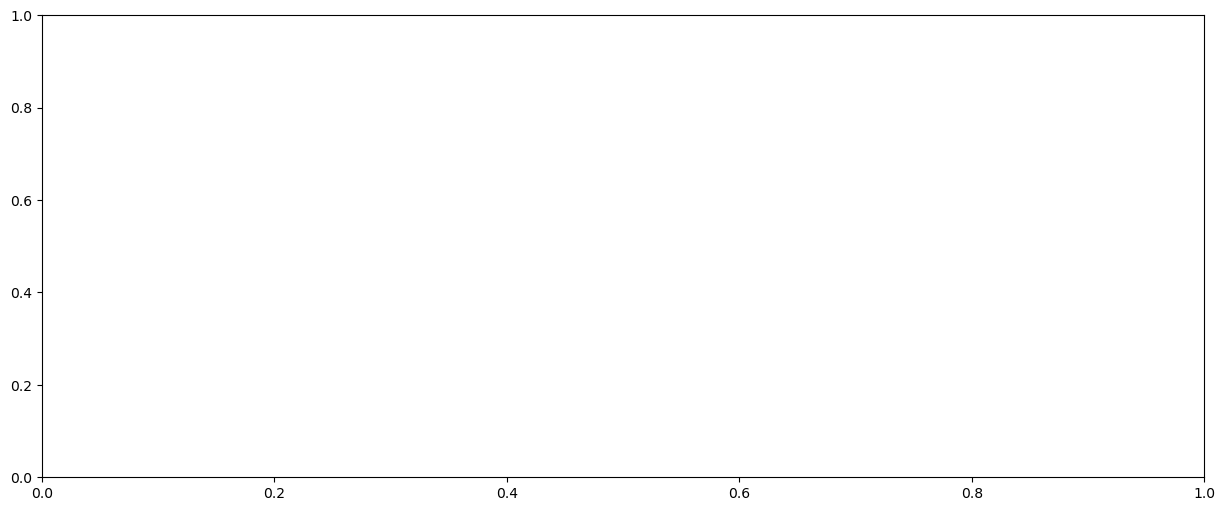

In [66]:
#Plot trials of same width together changing the dict_ridge_all key
search_key = ['M48', 'M49', 'M50', 'M51', 'M52', 'M53', 'M54', 'M55', 'M56', 'M57', 'M58', 'M59', 'M60', 'M61', 'M62']
dict_ridge_4mm = dict_percswings_all['all']


no_quad_to_plot = 200
TA_beg_PSTH_list = []
TA_end_PSTH_list = []
TAVel_beg_PSTH_list = []
class_value_list = []
Theta_theta_prime_list = []
TA_end_end_PSTH_list = []
a = 0
HA_traj_list = []
TA_traj_list = []
HA_traj_list_AngMom = []
TA_traj_list_AngMom = []
Ridge_traj_list = []
fig, ax1 = plt.subplots(1, 1, figsize=(15,6))
for i in np.arange(len(search_key)):
    res = dict(filter(lambda item: search_key[i] in item[0], dict_ridge_4mm.items())) 
#     res = excludeTATracesHighDerivative(res)
    res = excludeTATracesabove180(res)
    values_filename_list = list(res.values())
    key_filename_list = list(res.keys()) 
    for i in np.arange(len(key_filename_list)):
            Trial_classvalue = values_filename_list[i][-4]
            #print(Trial_classvalue)
            if Trial_classvalue ==1:
                RidgePert_classvalue = values_filename_list[i][-10]
                HA_traj = (values_filename_list[i][-1][4])
                TA_traj = (values_filename_list[i][-1][0])
                Ridge_traj = (values_filename_list[i][-1][6])/5
                if len(TA_traj) == 250 and len(HA_traj) == 250:# and TA_traj[120]>200:
                    plt.plot(TA_traj,'b', lw=2, alpha = 0.1)
                    plt.plot(Ridge_traj,'r', lw=2, alpha = 0.1)
                    TA_traj_list.append(np.diff(TA_traj))
                    HA_traj_list.append(np.diff(HA_traj))
                    Ridge_traj_list.append(-np.diff(Ridge_traj))
                    HA_AngMom = np.diff(HA_traj*40)
                    TA_AngMom = np.diff(TA_traj*8.15)
                    TA_traj_list_AngMom.append(np.trapz(TA_AngMom[100:160]))
                    HA_traj_list_AngMom.append(np.trapz(HA_AngMom[100:160]))

In [67]:
def plot_PSTH_Mean_STD_label_color_pre_assigned(mean_array, std_array, ax):
    clrs = sns.color_palette("husl", len(mean_array))
    label_strings = ['Tail', 'Ridge', 'Hip', 'Tail+Hip']#, 'Ipsi 4mm', 'Contra 4mm', 'Ipsi 4mm', 'Contra 4mm']
#    _, ax = plt.subplots(figsize=(12, 8))

    with sns.axes_style("darkgrid"):
        for i in range(len(mean_array)):
            mean_array[i] = smooth(mean_array[i], 10)[60:150]
            std_array[i] = smooth(std_array[i], 10)[60:150]
            x = np.linspace(0, len(mean_array[i])/300, len(mean_array[i]))
            ax.plot(x, mean_array[i], c=clrs[i], label = label_strings[i])
            ax.fill_between(x, mean_array[i]-std_array[i], mean_array[i]+std_array[i] ,alpha=0.3, facecolor=clrs[i])
            ax.legend(loc="upper right", fontsize = 13, frameon=False)
            ax.set_xlabel('Frame number (FR = 300 Hz)')
            ax.set_ylabel('Angular Momentum (g-cm2/s)')
            #ax.axvline(105,0,360, color = 'red')
            #ax.axvline(60,0,360, color = 'red')
            #ax.axvline(140,0,360, color = 'red')

    return ax

<ipython-input-61-59c9813e4b4d>:2: RuntimeWarning: Mean of empty slice
  mean_array = np.nanmean(array_value_dict, axis = 0)
C:\Users\Salvo\anaconda3\lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Salvo\anaconda3\lib\site-packages\numpy\core\_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\Salvo\anaconda3\lib\site-packages\numpy\core\_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: smooth only accepts 1 dimension arrays.

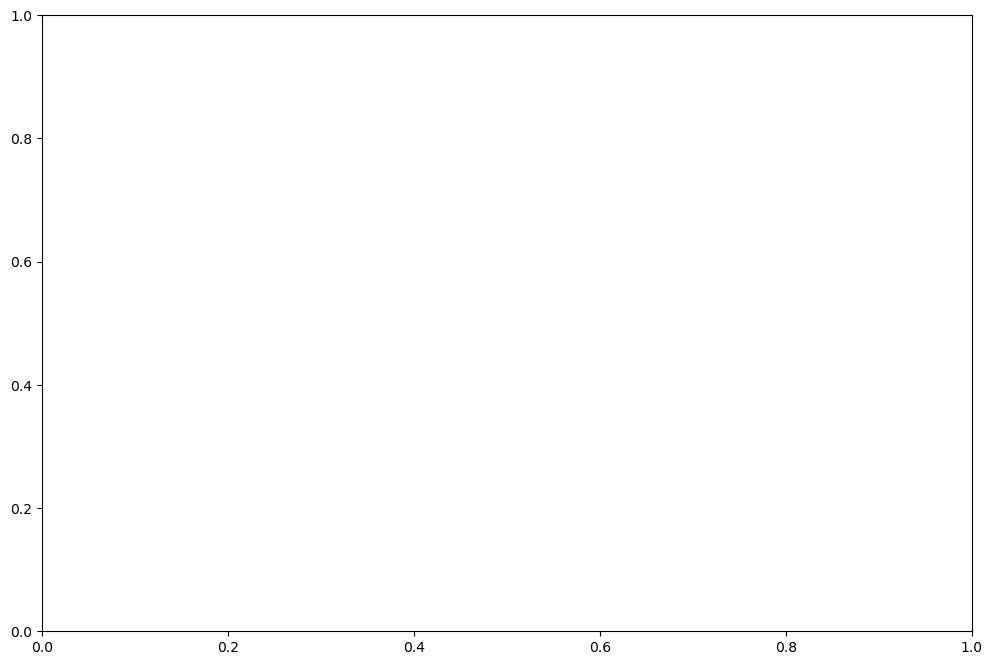

In [68]:
mean_TA, std_TA = return_Mean_STD_forPSTH(TA_traj_list)
mean_HA, std_HA = return_Mean_STD_forPSTH(HA_traj_list)
mean_Ridge, std_Ridge = return_Mean_STD_forPSTH(Ridge_traj_list)

mean_TA = mean_TA*8.15
mean_HA=mean_HA*40
mean_Ridge = mean_Ridge*25*5.5

means = [mean_TA, mean_Ridge, mean_HA, mean_HA+mean_TA]
stds = [std_TA*8.15, std_Ridge*25*5.5, std_HA*40, std_TA*8.15]

_, ax = plt.subplots(figsize=(12, 8))
clrs = sns.color_palette("husl", 5)

plot_PSTH_Mean_STD_label_color_pre_assigned(means, stds, ax)
ax.set_xlabel('Time (s)', fontsize=18)
ax.set_ylabel('Angular Momentum (g-cm2/s)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14) 
plt.savefig('out.svg', format='svg', dpi=1200)
print(np.trapz(mean_TA[60:110]), np.trapz(mean_HA[60:110]), np.trapz(mean_Ridge[60:110]))


In [ ]:
TA_traj_list_AngMom

In [ ]:
plt.scatter(TA_traj_list_AngMom, HA_traj_list_AngMom)


In [ ]:
#Plot BodyAxis for small swing (red) and big swing (green)
fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
small_swing_list = []
medium_swing_list = []
big_swing_list = []
for i in np.arange(len(Theta_theta_prime_list)):
    var_to_measure = Theta_theta_prime_list[i][8]
    if Theta_theta_prime_list[i][0] < 180:# and all(i < 50 for i in var_to_measure):
        #print(len(var_to_measure))
        ax1.plot(var_to_measure, 'r', lw=2, alpha = 0.3)
        if len(var_to_measure) == 259:
            small_swing_list.append(var_to_measure) 
    elif Theta_theta_prime_list[i][0] >180 and Theta_theta_prime_list[i][4] < 180:# and all(i < 50 for i in var_to_measure):
        ax1.plot(var_to_measure, 'g', lw=2, alpha = 0.3)
        if len(var_to_measure) == 259:
            medium_swing_list.append(var_to_measure) 
    elif Theta_theta_prime_list[i][0] > 180 and Theta_theta_prime_list[i][4] > 180:#  and all(i < 50 for i in var_to_measure):
        ax1.plot(var_to_measure, 'b', lw=2, alpha = 0.08)
        ax1.axvline(100,0,360, color = 'red')
 #       ax1.set_ylim(70, 120)
        ax1.set_ylim(230,310)
        if len(var_to_measure) == 259:
            big_swing_list.append(var_to_measure) 
plt.savefig('sample.png')

In [ ]:
#Plot COMY velocity for small swing (red) and big swing (green)
fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
small_swing_list = []
big_swing_list = []
for i in np.arange(len(Theta_theta_prime_list)):
    if Theta_theta_prime_list[i][0] < 180:
        ax1.plot(smooth(Theta_theta_prime_list[i][3], 10), 'r', lw=2, alpha = 0.3)
#         if len(Theta_theta_prime_list[i][11]) == 258:
#             small_swing_list.append(Theta_theta_prime_list[i][9]) 
    elif Theta_theta_prime_list[i][0] >180 and Theta_theta_prime_list[i][4] < 220:
        ax1.plot(smooth(Theta_theta_prime_list[i][3], 10), 'g', lw=2, alpha = 0.3)
#         if len(Theta_theta_prime_list[i][11]) == 258:
#             small_swing_list.append(Theta_theta_prime_list[i][9]) 
    elif Theta_theta_prime_list[i][0] > 180 and Theta_theta_prime_list[i][4] > 220:
        ax1.plot(smooth(Theta_theta_prime_list[i][3], 10), 'b', lw=2, alpha = 0.1)
        ax1.axvline(100,0,360, color = 'red')
#        plt.savefig('sample.png')
#         ax1.set_xlim(200, 250)
#         ax1.set_ylim(-2,3)
#         if len(Theta_theta_prime_list[i][9]) == 258:
#             big_swing_list.append(Theta_theta_prime_list[i][9]) 

plt.savefig('sample.png')

In [ ]:
#Plot COMX for small swing (red) and big swing (green)
fig, ax1 = plt.subplots(1, 1, figsize=(15,10))
small_swing_list = []
big_swing_list = []
for i in np.arange(len(Theta_theta_prime_list)):
    if Theta_theta_prime_list[i][0] < 180:
        ax1.plot(Theta_theta_prime_list[i][11], 'r', lw=2, alpha = 0.3)
#         if len(Theta_theta_prime_list[i][11]) == 258:
#             small_swing_list.append(Theta_theta_prime_list[i][9]) 
    elif Theta_theta_prime_list[i][0] >180 and Theta_theta_prime_list[i][4] < 180:
        ax1.plot(Theta_theta_prime_list[i][11], 'g', lw=2, alpha = 0.3)
#         if len(Theta_theta_prime_list[i][11]) == 258:
#             small_swing_list.append(Theta_theta_prime_list[i][9]) 
    elif Theta_theta_prime_list[i][0] > 180 and Theta_theta_prime_list[i][4] > 180:
        ax1.plot(Theta_theta_prime_list[i][11], 'b', lw=2, alpha = 0.1)
#         ax1.set_xlim(200, 250)
#         ax1.set_ylim(-2,3)
#         if len(Theta_theta_prime_list[i][9]) == 258:
#             big_swing_list.append(Theta_theta_prime_list[i][9]) 


In [ ]:
# def plot_PSTH_Mean_STD_label_color_pre_assigned(mean_array, std_array, ax):
clrs = sns.color_palette("husl", len(mean_array))
label_strings = ['Down 4mm', 'Up 4mm']#, 'Ipsi 4mm', 'Contra 4mm', 'Ipsi 4mm', 'Contra 4mm']
#    _, ax = plt.subplots(figsize=(12, 8))

with sns.axes_style("darkgrid"):
    for i in range(len(mean_array)):
        epochs = list(range(len(mean_array[i])))
        ax.plot(epochs, mean_array[i], c=clrs[i], label = label_strings[i])
        ax.fill_between(epochs, mean_array[i]-std_array[i], mean_array[i]+std_array[i] ,alpha=0.3, facecolor=clrs[i])
        ax.legend(loc="lower left")
        ax.set_xlabel('Frame number (FR = 300 Hz)')
        ax.set_ylabel('Angle (degree)')
        ax.axvline(60,0,360, color = 'red')
        ax.axvline(100,0,360, color = 'red')

return ax


In [ ]:
def plot_PSTH_Mean_STD_label_color_pre_assigned(mean_array, std_array, ax):
    clrs = sns.color_palette("husl", len(mean_array))
    label_strings = ['SS', 'MS', 'BS']#, 'Ipsi 4mm', 'Contra 4mm', 'Ipsi 4mm', 'Contra 4mm']
#    _, ax = plt.subplots(figsize=(12, 8))

    with sns.axes_style("darkgrid"):
        for i in range(len(mean_array)):
            epochs = list(range(len(mean_array[i])))
            ax.plot(epochs, mean_array[i], c=clrs[i], label = label_strings[i])
            ax.fill_between(epochs, mean_array[i]-std_array[i], mean_array[i]+std_array[i] ,alpha=0.3, facecolor=clrs[i])
            ax.legend(loc="lower left")
            ax.set_xlabel('Frame number (FR = 300 Hz)')
            ax.set_ylabel('Angle (degree)')
            ax.axvline(100,0,360, color = 'red')
            #ax.axvline(140,0,360, color = 'red')

    return ax

In [ ]:
mean_SS, std_SS = return_Mean_STD_forPSTH(small_swing_list)
mean_MS, std_MS = return_Mean_STD_forPSTH(medium_swing_list)
mean_BS, std_BS = return_Mean_STD_forPSTH(big_swing_list)
means = [mean_SS, mean_MS, mean_BS]
stds = [std_SS, std_MS, std_BS]

_, ax = plt.subplots(figsize=(12, 8))
clrs = sns.color_palette("husl", 5)

plot_PSTH_Mean_STD_label_color_pre_assigned(means, stds, ax)
# ax.set_xlim(50,200)
# ax.set_ylim(-1,3)
plt.savefig('sample.png')

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,6))
for i in np.arange(len(Theta_theta_prime_list)):
#    print(Theta_theta_prime_list[i][4])
    if Theta_theta_prime_list[i][4] > 180:
        #fig, ax1 = plt.subplots(1, 1, figsize=(15,6))
        #plt.scatter(Theta_theta_prime_list[i][1], Theta_theta_prime_list[i][2], c = 'b')
        #ax1.plot(Theta_theta_prime_list[i][3], 'b')
        #ax1.plot(np.diff(Theta_theta_prime_list[i][5]), 'g')
        ax1.plot(np.diff(Theta_theta_prime_list[i][6]), 'r')

In [ ]:
#Plot data in 3D binned wrt type of tail response

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for i in np.arange(len(Theta_theta_prime_list)):
#    print(Theta_theta_prime_list[i][4])
    if Theta_theta_prime_list[i][0] < 50000:
        #print(Theta_theta_prime_list[i][1], Theta_theta_prime_list[i][2] )
        ax.scatter(Theta_theta_prime_list[i][2], Theta_theta_prime_list[i][1], \
                      Theta_theta_prime_list[i][0], c = 'b')
#     elif Theta_theta_prime_list[i][0] > 180 and Theta_theta_prime_list[i][4] < 250:
#         #print(Theta_theta_prime_list[i][1], Theta_theta_prime_list[i][2] )
#         ax.scatter(Theta_theta_prime_list[i][2], Theta_theta_prime_list[i][1], \
#                       Theta_theta_prime_list[i][0], c = 'g')
#     elif Theta_theta_prime_list[i][0] > 180 and Theta_theta_prime_list[i][4] > 250:
#         #print(Theta_theta_prime_list[i][1], Theta_theta_prime_list[i][2] )
#         ax.scatter(Theta_theta_prime_list[i][2], Theta_theta_prime_list[i][1], \
#                       Theta_theta_prime_list[i][0], c = 'r')        


In [ ]:
#Use SVD to calculate best fitting line in 3D data


x = [item[2] for item in Theta_theta_prime_list] 
y = [item[1] for item in Theta_theta_prime_list]
z = [item[0] for item in Theta_theta_prime_list]

#Mean corrected
x = x-np.nanmean(x)
y = y-np.nanmean(y)
z = z-np.nanmean(z)


data = np.stack((x,y,z),axis = 1)

#data = data[0:20]

# Calculate the mean of the points, i.e. the 'center' of the cloud
datamean = np.nanmean(data, axis=0)

#dropped nan

data = np.array([x for x in data if ~np.isnan(np.mean(x))])

# Do an SVD on the mean-centered data.
uu, dd, vv = np.linalg.svd(data)# - datamean)

# # Now vv[0] contains the first principal component, i.e. the direction
# # vector of the 'best fit' line in the least squares sense.

# # Now generate some points along this best fit line, for plotting.

# # I use -7, 7 since the spread of the data is roughly 14
# # and we want it to have mean 0 (like the points we did
# # the svd on). Also, it's a straight line, so we only need 2 points.
linepts = vv[0] * np.mgrid[-100:100:2j][:, np.newaxis]

# shift by the mean to get the line in the right place
linepts += datamean

# Verify that everything looks right.

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as m3d

ax = m3d.Axes3D(plt.figure())
ax.scatter3D(*data.T)
ax.plot3D(*linepts.T)
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
import pandas as pd

#fit regression model
model = LinearRegression()
x = [item[2] for item in Theta_theta_prime_list] 
y = [item[1] for item in Theta_theta_prime_list]
z = [item[0] for item in Theta_theta_prime_list]
#Mean corrected
# x = x-np.nanmean(x)
# y = y-np.nanmean(y)
# z = z-np.nanmean(z)
data = np.stack((x,y,z),axis = 1)
# Calculate the mean of the points, i.e. the 'center' of the cloud
datamean = np.nanmean(data, axis=0)
#dropped nan
data = np.array([x for x in data if ~np.isnan(np.mean(x))])
# x = np.array([item[0] for item in data])
# y = np.array([item[1] for item in data])
# z = np.array([item[2] for item in data])

# #Reshape
# x = x.reshape(-1, 1)
# y = y.reshape(-1, 1)
# z = z.reshape(-1, 1)

# bla = np.concatenate(x, axis = 0)
# bla2 = np.concatenate(y, axis = 0)
# bla3 = np.concatenate(z, axis = 0)
#model.fit(x, y)

#display adjusted R-squared
#1 - (1-model.score(x, y))*(len(y)-1)/(len(y)-x.shape[1]-1)


In [ ]:
f, ax = plt.subplots(figsize=(5, 6))
sns.set_theme(color_codes=False)
#tips = sns.load_dataset("tips")
#data_bla = np.concatenate((bla, bla),axis = 0)

sns.regplot(x=z, y=x)#, data=data_bla);
plt.show

In [ ]:
def assign_quadrant_classifier_equal_number(TA, no_quad, list_of_TAMeans_equally_split):
    classifier = []
    #print(len(list_of_TAMeans_equally_split))
    for i in np.arange(len(list_of_TAMeans_equally_split)):
        first_value = list_of_TAMeans_equally_split[i][0]
        last_value = list_of_TAMeans_equally_split[i][-1]
        if first_value <= TA <= last_value:
            classifier = i
    return classifier

In [ ]:
#Split traces into N equally populated arrays
dict_ridge_4mm = dict_ridge_all['all']
dict_traces_divided_on_TA_at_pert_time = defaultdict(dict)
class_value_list = []
TA_end_PSTH_list_array = np.array(TA_end_PSTH_list)
TA_end_PSTH_list_woutNaN = TA_end_PSTH_list_array[~numpy.isnan(TA_end_PSTH_list_array)]
TA_end_PSTH_list_woutNaN.sort()
list_of_TAMeans_eq_split = splitsequenceequally(TA_end_PSTH_list_woutNaN,no_quad_to_plot)
for i in np.arange(len(search_key)):
    res = dict(filter(lambda item: search_key[i] in item[0], dict_ridge_4mm.items())) 
    res = excludeTATracesHighDerivative(res)
    res = excludeTATracesabove180(res)
    values_filename_list = list(res.values())
    key_filename_list = list(res.keys()) 
    for i in np.arange(len(key_filename_list)):
        Trial_classvalue = values_filename_list[i][7]
        TA_traj = values_filename_list[i][-3]
        if Trial_classvalue == 1:
            TA_at_pert_time = np.mean(TA_traj[100:105])
            quadrant_value = assign_quadrant_classifier_equal_number(TA_at_pert_time, no_quad_to_plot, list_of_TAMeans_eq_split)
            class_value_list.append([TA_traj, quadrant_value])

    dict_traces_divided_on_TA_at_pert_time[key_filename_list[i]] = class_value_list

In [ ]:
##### Assign TA list for each quadrant in dict
values_list = list(dict_traces_divided_on_TA_at_pert_time.values())
key_list = list(dict_traces_divided_on_TA_at_pert_time.keys()) 
dict_mean_quadrants = defaultdict(dict)
for k in range(no_quad_to_plot):
    TA_traj_list = []
    for i in np.arange(len(key_list)):
        for j in np.arange(len(values_list[i])):
            TA_traj = values_list[i][j][0]
            quad_class = values_list[i][j][1]
            if quad_class == k and len(TA_traj):# == 169:
                TA_traj_list.append(TA_traj)
    dict_mean_quadrants[k] = TA_traj_list

In [ ]:
#Plot quadrants
values_list = list(dict_mean_quadrants.values())
key_list = list(dict_mean_quadrants.keys()) 

for i in np.arange(len(key_list)):
    fig, ax1 = plt.subplots(1, 1, figsize=(15,6))
    values_quad = values_list[i]
    for j in np.arange(len(values_quad)):
        ax1.plot(values_quad[j])

In [ ]:
%matplotlib inline


In [ ]:

values_list = list(dict_mean_quadrants.values())
key_list = list(dict_mean_quadrants.keys()) 
color_idx = np.linspace(0, 1, no_quad_to_plot)
fig, ax1 = plt.subplots(1, 1, figsize=(15,10))

for color_i, i in zip(color_idx, np.arange(no_quad_to_plot)):#len(key_list)):
    mean_quadrant_traces = np.nanmean(dict_mean_quadrants[i], axis=0)
    data = mean_quadrant_traces#-mean_quadrant_traces[50]
    #Plot here
    plt.plot(data, color=plt.cm.coolwarm(color_i), lw=4, alpha = 0.7, label="%s quadrant" % (i+1))
    plt.legend()
    plt.xlabel('Frame number (FR = 300 Hz)', size = 15)
    plt.ylabel('Tail Angle (degree)', size = 15)
    plt.axvline(60,0,360, color = 'red')
    plt.axvline(100,0,360, color = 'red')
    #plt.xlim(30,120)
    plt.savefig('sample.png')
plt.show()


In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
values_list = list(dict_mean_quadrants.values())
key_list = list(dict_mean_quadrants.keys()) 
color_idx = np.linspace(0, 1, no_quad_to_plot)
#fig, ax1 = plt.subplots(1, 1, figsize=(15,6))
for color_i, i in zip(color_idx, np.arange(len(values_list))):#len(key_list)):
    #fig, ax1 = plt.subplots(1, 1, figsize=(15,6))

    mean_quadrant_traces = np.nanmean(dict_mean_quadrants[i], axis=0)
    if isinstance(mean_quadrant_traces, float):
        print(mean_quadrant_traces)
    else:
        mean_quadrant_traces_der = np.diff(mean_quadrant_traces)
        velocity_at_pert_time = (mean_quadrant_traces[60]-mean_quadrant_traces[55])/6
        ax.scatter(mean_quadrant_traces[60], velocity_at_pert_time, mean_quadrant_traces[100], color=plt.cm.coolwarm(color_i), lw=3, alpha = 0.5)

        #ax.xlabel('Tail Angle (degree)', size = 13)
        #ax.ylabel('Tail Velocity (degree/timepoint)', size = 13)
        #plt.savefig('sample.png')


In [ ]:
####CHECKED INDEXES IN DICT_ALL UNTIL HERE##########################################

In [ ]:
#Scatter of TA and TA derivative to check that the tail response depends on the position of the tail and
#its velocity
#Plot trials of same width together changing the dict_ridge_all key
search_key = ['M48', 'M49', 'M50', 'M51', 'M52', 'M53', 'M54', 'M55', 'M56', 'M57', 'M58', 'M59', 'M60', 'M61', 'M62']
dict_ridge_4mm = dict_ridge_all['4mm']

no_quad_to_plot = 20
dict_traces_divided_on_TA_at_pert_time = defaultdict(dict)

class_value_list = []
#fig, ax1 = plt.subplots(1, 1, figsize=(15,6))
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
for i in np.arange(len(search_key)):
    res = dict(filter(lambda item: search_key[i] in item[0], dict_ridge_4mm.items())) 
    res = excludeTATracesHighDerivative(res)
#    res = flip_traces_above_180(res)
    values_filename_list = list(res.values())
    key_filename_list = list(res.keys()) 
#    fig, ax1 = plt.subplots(1, 1, figsize=(15,6))
#    fig = plt.figure()
    for color_i, i in zip(color_idx,np.arange(len(key_filename_list))):
#        print(key_filename_list)
        Trial_classvalue = values_filename_list[i][7]
        TA_traj = smooth(values_filename_list[i][-1], 20)
        TA_traj_der = np.diff(TA_traj)
        Ridge_traj = values_filename_list[i][9]
        n = 7 #column in dict with trial classifier
        dict_trial_classifier = {k:v[n] for k,v in res.items()}
        dict_trial_classifier_value = list(dict_trial_classifier.values())
        count_ipsi_trials = dict_trial_classifier_value.count(1)
        #print(len(TA_traj[0:-1]), len(TA_traj_der))
        if Trial_classvalue == 1:# and len(TA_traj) == 169:
            #plt.scatter(TA_traj[0:-1], TA_traj_der)
            z =  list(range(0, 168))
            ax.scatter(z, TA_traj[0:-1], TA_traj_der, color=plt.cm.coolwarm(color_i), marker='o')
plt.show()
            #plt.plot(Ridge_traj, 'k')
            #plt.ylim(110, 250)
#             #plt.xlim(55, 98)
#             TA_at_pert_time = np.mean(TA_traj[55:60])
#             quadrant_value = assign_quadrant_classifier(TA_at_pert_time, no_quad_to_plot)
# #             class_value_list.append([smooth(TA_traj,20), quadrant_value])
# #                 #print(quadrant_value)
# #     dict_traces_divided_on_TA_at_pert_time[key_filename_list[i]] = class_value_list



In [ ]:
#Write function to extract only ipsi trials from dict_all specific width and asign it to array
def return_Ipsi_trials_array(width):
    dict_ridge_4mm = dict_ridge_all[width]
    search_key = ['M48', 'M49', 'M50', 'M51', 'M52', 'M53', 'M54', 'M55', 'M56', 'M57', 'M58', 'M59', 'M60', 'M61', 'M62']

    TA_traj_4mm_ipsi = []
    for i in np.arange(len(search_key)):
        res = dict(filter(lambda item: search_key[i] in item[0], dict_ridge_4mm.items())) 
        values_filename_list = list(res.values())
        key_filename_list = list(res.keys())   
        for i in np.arange(len(key_filename_list)):
            Trial_classvalue = values_filename_list[i][7]
            TA_traj = values_filename_list[i][10]
            if Trial_classvalue == 1 and len(TA_traj) == 150: ###BE CAREFUL HERE IF I CHANGE WIDTH OF PSTH:
                TA_traj_4mm_ipsi.append(TA_traj)
    return TA_traj_4mm_ipsi


In [ ]:
#Write function to extract only contra trials from dict_all specific width and asign it to array
def return_Contra_trials_array(width):
    dict_ridge_4mm = dict_ridge_all[width]
    search_key = ['M48', 'M49', 'M50', 'M51', 'M52', 'M53', 'M54', 'M55', 'M56', 'M57', 'M58', 'M59', 'M60', 'M61', 'M62']

    TA_traj_4mm_contra = []
    for i in np.arange(len(search_key)):
        res = dict(filter(lambda item: search_key[i] in item[0], dict_ridge_4mm.items())) 
        values_filename_list = list(res.values())
        key_filename_list = list(res.keys())   
        for i in np.arange(len(key_filename_list)):
            Trial_classvalue = values_filename_list[i][7]
            TA_traj = values_filename_list[i][10]
            if Trial_classvalue == -1 and len(TA_traj) == 150: ###BE CAREFUL HERE IF I CHANGE WIDTH OF PSTH
                TA_traj_4mm_contra.append(TA_traj)
    return TA_traj_4mm_contra

In [ ]:
#Divide ipsi 4 mm traces based on whether they are going down or up
def Divide_TATraces_UpVSDown(TA_traj_4mm_ipsi):
    TA_traces_goingDOWN = []
    TA_traces_goingUP = []

    for i in np.arange(len(TA_traj_4mm_ipsi)):
        TA_chunk = TA_traj_4mm_ipsi[i]
        TA__chunk_afterTilt = TA_chunk[120:140]
        TA__chunk_beforeTilt = TA_chunk[0:60]
        TA__chunk_afterTilt_mean = np.nanmean(TA__chunk_afterTilt)
        TA__chunk_beforeTilt_mean = np.nanmean(TA__chunk_beforeTilt)
        thresh_trial_down = 180
        thresh_trial_up = 270

        if 0 < TA__chunk_afterTilt_mean < 150:
            TA_traces_goingDOWN.append(TA_chunk)
        elif 240 < TA__chunk_afterTilt_mean <360 and TA__chunk_beforeTilt_mean < 180:
            TA_traces_goingUP.append(TA_chunk)
    return TA_traces_goingDOWN, TA_traces_goingUP


In [ ]:
def plot_PSTH_Mean_STD(mean_array, std_array, ax, label_strings, color):
#    clrs = sns.color_palette("husl", len(mean_array))
#    label_strings = ['Down 4mm', 'Up 4mm', 'Ipsi 4mm', 'Contra 4mm', 'Ipsi 4mm', 'Contra 4mm']
#    _, ax = plt.subplots(figsize=(12, 8))

    with sns.axes_style("darkgrid"):
        for i in range(len(mean_array)):
            epochs = list(range(len(mean_array[i])))
            ax.plot(epochs, mean_array[i], c=color, label = label_strings[i])
            ax.fill_between(epochs, mean_array[i]-std_array[i], mean_array[i]+std_array[i] ,alpha=0.3, facecolor=color)
            ax.legend(loc="lower left")
            ax.set_xlabel('Frame number (FR = 300 Hz)')
            ax.set_ylabel('Angle (degree)')
            ax.axvline(60,0,360, color = 'red')
            ax.axvline(100,0,360, color = 'red')
    return ax

In [ ]:
def plot_PSTH_Mean_STD_label_color_pre_assigned(mean_array, std_array, ax):
    clrs = sns.color_palette("husl", len(mean_array))
    label_strings = ['Down 4mm', 'Up 4mm']#, 'Ipsi 4mm', 'Contra 4mm', 'Ipsi 4mm', 'Contra 4mm']
#    _, ax = plt.subplots(figsize=(12, 8))

    with sns.axes_style("darkgrid"):
        for i in range(len(mean_array)):
            epochs = list(range(len(mean_array[i])))
            ax.plot(epochs, mean_array[i], c=clrs[i], label = label_strings[i])
            ax.fill_between(epochs, mean_array[i]-std_array[i], mean_array[i]+std_array[i] ,alpha=0.3, facecolor=clrs[i])
            ax.legend(loc="lower left")
            ax.set_xlabel('Frame number (FR = 300 Hz)')
            ax.set_ylabel('Angle (degree)')
            ax.axvline(60,0,360, color = 'red')
            ax.axvline(100,0,360, color = 'red')

    return ax

In [ ]:
def return_mean_and_derivatives(array_value_dict):
    mean_array = smooth(np.nanmean(array_value_dict, axis = 0), 10)   
    mean_array_1st_der = np.diff(mean_array)
    mean_array_2nd_der = np.diff(mean_array_1st_der)
    return mean_array, mean_array_1st_der, mean_array_2nd_der

In [ ]:
def return_STD_and_derivatives(array_value_dict):
    STD_array = smooth(stats.sem(array_value_dict, nan_policy='omit'), 10)
    STD_array_1st_der = np.diff(STD_array)
    STD_array_2nd_der = np.diff(STD_array_1st_der)
    return STD_array, STD_array_1st_der, STD_array_2nd_der

In [ ]:
#Extract ipsi traces for one width, divide them into up and down and return in concatenated array
def return_traces_UP_DOWN_X_width(width):
    TA_ipsi_4mm = return_Ipsi_trials_array(width)
    TA_ipsi_4mm_DOWN, TA_ipsi_4mm_UP = Divide_TATraces_UpVSDown(TA_ipsi_4mm)
    TA_traces_UPDOWN = [TA_ipsi_4mm_DOWN, TA_ipsi_4mm_UP]    
    return TA_traces_UPDOWN

In [ ]:
#Extract traces and divide them into IPSI and CONTRA and return in concatenated array
def return_traces_IPSI_CONTRA_X_width(width):
    TA_ipsi_xmm = return_Ipsi_trials_array(width)
    TA_contra_xmm = return_Contra_trials_array(width)
    TA_traces_IpsiContra = [TA_ipsi_xmm, TA_contra_xmm]    
    return TA_traces_IpsiContra

In [ ]:
#Return TA mean and STD trace, and their 1st and 2nd order derivative in concatenated array
def return_MeanSTD_and_derivatives_UpVsDown(TA_traces_UPDOWN):
    mean_array = []
    STD_array = []
    for i in np.arange(len(TA_traces_UPDOWN)):
        mean_raw, mean_1stDer, mean_2ndDer = return_mean_and_derivatives(TA_traces_UPDOWN[i])
        mean_array.append([mean_raw, mean_1stDer, mean_2ndDer])
        STD1_raw, STD_1stDer, STD_2ndDer = return_STD_and_derivatives(TA_traces_UPDOWN[i])
        STD_array.append([STD1_raw, STD_1stDer, STD_2ndDer])
    return mean_array, STD_array

In [ ]:
#Return TA mean and STD trace, and their 1st and 2nd order derivative in concatenated array
def return_MeanSTD_and_derivatives_IpsiVsContra(TA_traces_IpsiContra):
    mean_array = []
    STD_array = []
    for i in np.arange(len(TA_traces_IpsiContra)):
        mean_raw, mean_1stDer, mean_2ndDer = return_mean_and_derivatives(TA_traces_IpsiContra[i])
        mean_array.append([mean_raw, mean_1stDer, mean_2ndDer])
        STD1_raw, STD_1stDer, STD_2ndDer = return_STD_and_derivatives(TA_traces_IpsiContra[i])
        STD_array.append([STD1_raw, STD_1stDer, STD_2ndDer])
    return mean_array, STD_array

In [ ]:
#Unpack traces and its derivatives and arrange them such that each array has one Up and one Down traces 
#(pairing with derivative order)
def return_traces_derivatives(mean_array, STD_array):
    mean_array_unpacked = [item for sublist in mean_array for item in sublist]
    STD_array_unpacked = [item for sublist in STD_array for item in sublist]

    mean_array_unpacked_no_der = [mean_array_unpacked[0], mean_array_unpacked[3]]
    STD_array_unpacked_no_der = [STD_array_unpacked[0], STD_array_unpacked[3]]
    mean_array_unpacked_1st_der = [mean_array_unpacked[1], mean_array_unpacked[4]]
    STD_array_unpacked_1st_der = [STD_array_unpacked[1], STD_array_unpacked[4]]
    mean_array_unpacked_2nd_der = [mean_array_unpacked[2], mean_array_unpacked[5]]
    STD_array_unpacked_2nd_der = [STD_array_unpacked[2], STD_array_unpacked[5]]

    mean_array_unpacked_rearranged = [mean_array_unpacked_no_der, mean_array_unpacked_1st_der, mean_array_unpacked_2nd_der]
    STD_array_unpacked_rearranged = [STD_array_unpacked_no_der, STD_array_unpacked_1st_der, STD_array_unpacked_2nd_der]
    return mean_array_unpacked_rearranged, STD_array_unpacked_rearranged

In [ ]:
#Script to obtain all traces divided into UPs and Down in different column of array
width_key = ['4mm', '5mm', '8mm', '10mm']
mean_array_unpacked_all = []
STD_array_unpacked_all = []

for key in width_key:
    TA_traces_UPDOWN = return_traces_UP_DOWN_X_width(key)
    mean_array, STD_array = return_MeanSTD_and_derivatives_UpVsDown(TA_traces_UPDOWN)
    mean_array_unpacked, STD_array_unpacked = return_traces_derivatives(mean_array, STD_array)
    mean_array_unpacked_all.append(mean_array_unpacked)
    STD_array_unpacked_all.append(STD_array_unpacked)

In [ ]:
#Script to obtain all traces divided into Ipsi vs Contra in different column of array
width_key = ['4mm', '5mm', '8mm', '10mm']
mean_array_unpacked_all_IpsiContra = []
STD_array_unpacked_all_IpsiContra = []

for key in width_key:
    TA_traces_IpsiContra = return_traces_IPSI_CONTRA_X_width(key)
    mean_array, STD_array = return_MeanSTD_and_derivatives_IpsiVsContra(TA_traces_IpsiContra)
    mean_array_unpacked, STD_array_unpacked = return_traces_derivatives(mean_array, STD_array)
    mean_array_unpacked_all_IpsiContra.append(mean_array_unpacked)
    STD_array_unpacked_all_IpsiContra.append(STD_array_unpacked)

In [ ]:
for i in np.arange(4):
    plt.plot((mean_array_unpacked_all_IpsiContra[i][0][1]))
    plt.plot((STD_array_unpacked_all_IpsiContra[i][0][1]))

In [ ]:
for i in np.arange(4):
    plt.plot((mean_array_unpacked_all[i][0][1]))
    plt.plot((STD_array_unpacked_all[i][0][1]))

In [ ]:
#Plot traces color paired based on Ups or Downs
_, ax = plt.subplots(figsize=(12, 8))
clrs = sns.color_palette("husl", 4)

for i in np.arange(4):
    plot_PSTH_Mean_STD_label_color_pre_assigned(mean_array_unpacked_all[i][0], STD_array_unpacked_all[i][0], ax)

In [ ]:
#Plot traces color paired based on width
_, ax = plt.subplots(figsize=(12, 8))
label_strings = [['Down 4mm', 'Up 4mm'], ['Down 5mm', 'Up 5mm'], ['Down 8mm', 'Up 8mm'], ['Down 10mm', 'Up 10mm']]
clrs = sns.color_palette("husl", 4)

for i in np.arange(4):
    plot_PSTH_Mean_STD(mean_array_unpacked_all[i][0], STD_array_unpacked_all[i][0], ax, label_strings[i], clrs[i])


In [ ]:
_, ax = plt.subplots(figsize=(12, 8))
for i in np.arange(4):
    plot_PSTH_Mean_STD_label_color_pre_assigned(mean_array_unpacked_all[i][1], STD_array_unpacked_all[i][1], ax)

In [ ]:
_, ax = plt.subplots(figsize=(12, 8))
for i in np.arange(4):
    plot_PSTH_Mean_STD_label_color_pre_assigned(mean_array_unpacked_all[i][2], STD_array_unpacked_all[i][2], ax)

In [ ]:
#Plot traces color paired based on width IPSI VS CONTRA
_, ax = plt.subplots(figsize=(12, 8))
label_strings = [['Down 4mm', 'Up 4mm'], ['Down 5mm', 'Up 5mm'], ['Down 8mm', 'Up 8mm'], ['Down 10mm', 'Up 10mm']]
clrs = sns.color_palette("husl", 4)

for i in np.arange(4):
    plot_PSTH_Mean_STD(mean_array_unpacked_all_IpsiContra[i][0], STD_array_unpacked_all_IpsiContra[i][0], ax, label_strings[i], clrs[i])

In [ ]:
_, ax = plt.subplots(figsize=(12, 8))
for i in np.arange(4):
    plot_PSTH_Mean_STD_label_color_pre_assigned(mean_array_unpacked_all_IpsiContra[i][1], STD_array_unpacked_all_IpsiContra[i][1], ax)

In [ ]:
_, ax = plt.subplots(figsize=(12, 8))
for i in np.arange(4):
    plot_PSTH_Mean_STD_label_color_pre_assigned(mean_array_unpacked_all_IpsiContra[i][2], STD_array_unpacked_all_IpsiContra[i][2], ax)